# Data Project about electricity price forecasting in switzerland (Day Ahead)

This Project and Modul work is about forecasting whole sale energy market prices for switzerland. <br>
**Hereby a short foreword about switzerland and it's meaning to electricity market:** <br>
Switzerland is in the heart of Europe. This is also of great importance for the energy market.
Even if Switzerland plays a subordinate role in the context of European electricity consumption and production, it is a hub for the energy market for energy exchange from north to south.
The Swiss energy market price is strongly influenced by this and this should be taken into account in a model for predicting the electricity price in Switzerland. This means that the system prices of the major electricity countries (such as Germany, France and Italy) have a major influence on price formation in Switzerland. <br>

The following picture gives an overview of the drivers that we consider in this thesis in order to realize a price forecast.

<html> 
    <body> 
        <div class="row">
            <div class="column"> 
                  <img src = "System_picture.jpg" style="width:600;height:415px" align="left">
            </div>
            <div class="column"> 
                  <img src = "Legend_system_picture.jpg" style="width:300;height:175px" >
            </div>
       </div>
    </body>
</html>

So the driver we are going to consider for a price forescasting for switzerland is
- consumption 
- renewable production
- conventional Generation
- transmission between the bidding zone

all this data is considered for 
- switzerland (as the main focus)
- but also for the important sourrounding countries - Germany, France and Italy (so excplicitly not considered is Austria)

**some further Notes**
- Austria will not be considered because there is only a weak connection to this country (compared to the others). Nevertheless the connection to Austria will be added in the summation for the overall northern boder of switzerland (as overall exchange capacity).
- Concerning Italy (which is itself devided by bidding zone) only the market zone to switzerland will be considered, say Italy North.
- the data we are considering are *forecasting data*. This is not equal the *actual data* <u>but</u> the data which is provided by the transmission system operaters (TSO) of the bidding zones. Background&reason: the price bidding will be done on forcasted data and not on basis of actual data.  

### Data

We will use data of following sources in this project:

- epex market : for price data of system prices (Day Ahead Market) of switzerland and germany. I get them internally within my company, because a login is required <br>
- transparency plattform : https://transparency.entsoe.eu/ , here you can register and have access to all data needed! <br> <br>

Although we load data from epex, we won't use them for forecasting - we only use them to make a consistency testing with data from the transparency plattform. The transparency plattform provides price data as well for all bidding zones.<br>
In the end we only gonna use the data from transperncy plattform. <br>
Transparency plattform als provides and API (the so called *restful API*). As the API usage would give further work to implement this is not implemented in the project work yet.


### Goal
The Goal of this Modul Project is:
- provide a 24-hours forcast for the day ahead market Switzerland (SWISSIX)
- compare different Models for forecasting


### Structure of the project work

1. Data loading 
    - read in EPEX Data
    - read in Transparency Data
2. Data Examination 
    - Structure of Prices
    - Correlation Prices vs. *drivers* (drivers are mentioned above)
3. Setup Fitting Model(s)

# 1. Data loading

## Following Moduls of Python (to load/use in this and other sections)
(Attention: There will be more Moduls to load in the upcoming sections)

In [1]:
# ... 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pandas as pd
from scipy import stats
from datetime import datetime

## 1.1. Reading EPEX Data from Excel (downloadable from EPEX Plattform, for authorized users only)
**how to read** <br>
The Data gives a table out of the hourly prices for each day.<br>
HourX means *price for hour X-1 to X*, so Hour1 means price for the hour 00:00 till 01:00 for buying or selling electricity in switzerland at the Day Ahead Market.<br>
The date is given in the column 2, *delivery day*
In the columns further right are different products listed. As not of interest to us, there will be no further comments on them. <br>


<u>Important to notice: </u> <br>
As we deal quite a bit with time series, it's important to know that we'll load all data from transparency plattform with time zone UTC.
EPEX Data however is in time zone CET - means +2h .<br>
This has to be accounted when comparing data. 



In [2]:
#read in data and show
epex_df = pd.read_excel("./data_V2/Preis_aktuell_Spot_EEX_CH-19.xlsx", header=[1], sheet_name='Prices')
epex_df

Delivery day  Hour1  Hour2  Hour3A  Hour3B  Hour4  Hour5  Hour6  Hour7  \
0     2019-12-31  35.13  32.37   30.02     NaN  28.57  28.53  31.41  35.94   
1     2019-12-30  27.57  25.87   22.60     NaN  19.66  19.65  22.31  27.99   
2     2019-12-29  28.33  26.41   25.13     NaN  22.10  21.07  22.13  21.78   
3     2019-12-28  33.03  30.49   29.44     NaN  28.35  28.42  29.34  28.91   
4     2019-12-27  33.58  32.78   31.75     NaN  31.06  31.23  32.37  36.06   
..           ...    ...    ...     ...     ...    ...    ...    ...    ...   
360   2019-01-05  63.06  58.48   54.73     NaN  52.53  51.58  52.52  52.94   
361   2019-01-04  52.59  51.69   49.95     NaN  48.41  48.12  50.33  54.03   
362   2019-01-03  53.03  50.50   48.32     NaN  45.44  45.49  49.94  54.97   
363   2019-01-02  49.97  48.66   41.56     NaN  43.07  38.60  49.21  52.54   
364   2019-01-01  50.26  48.74   47.24     NaN  36.29  30.09  27.31  28.53   

     Hour8  ...  Night\n(01-06)  Off Peak I\n(01-08)  Business Hours\n(09-16)  \
0    42.01  ...           31.01                33.00                    38.70   
1    38.99  ...           22.94                25.58                    39.64   
2    26.23  ...           24.20                24.15                    28.59   
3    31.73  ...           29.85                29.96                    35.51   
4    40.90  ...           32.13                33.72                    42.85   
..     ...  ...             ...                  ...                      ...   
360  54.07  ...           55.48                54.99                    61.84   
361  65.95  ...           50.18                52.63                    69.27   
362  66.88  ...           48.79                51.82                    68.40   
363  54.99  ...           45.18                47.33                    62.38   
364  26.84  ...           39.99                36.91                    39.27   

     Off Peak\n(01-08 & 21-24)  Morning\n(07-10)  High Noon\n(11-14)  \
0                        34.39             40.46               37.69   
1                        30.33             37.39               38.78   
2                        27.61             26.20               28.71   
3                        31.20             33.24               34.99   
4                        35.19             41.09               42.22   
..                         ...               ...                 ...   
360                      57.37             58.10               63.34   
361                      56.74             64.98               69.57   
362                      55.47             65.22               68.56   
363                      52.12             58.10               63.19   
364                      42.61             29.94               40.73   

     Afternoon\n(15-18)  Evening\n(19-24)  Sunpeak\n(11-16)  Sun Peak\n(10-16)  
0                 39.62             39.23             37.62                NaN  
1                 41.88             42.07             39.09                NaN  
2                 31.85             36.34             28.66                NaN  
3                 38.60             36.24             35.30                NaN  
4                 45.30             40.95             42.57                NaN  
..                  ...               ...               ...                ...  
360               60.25             64.11             61.56                NaN  
361               69.23             67.01             69.03                NaN  
362               68.44             65.65             68.02                NaN  
363               63.42             64.45             62.36                NaN  
364               46.69             53.99             41.63                NaN  

[365 rows x 47 columns]

The next statement is setting a time index for column *delivery day* <br>
This is important because we want to select row information by dates <br>


In [3]:
#convert Delivery day to a date time column
epex_df['Delivery day'] = pd.to_datetime(epex_df['Delivery day'], format = '%Y%m%d')

Now we are able to get i.e. all prices of 2019 on a specific day at a specific hour of the EPEX Data<br>
<u>Example:</u> let's get hour 9 for tuesdays in 2019


Text(0.5, 1.0, 'Hourly Day Ahead Prices on Tuesdays at hour 9 of Electricity Market for Switzerland')

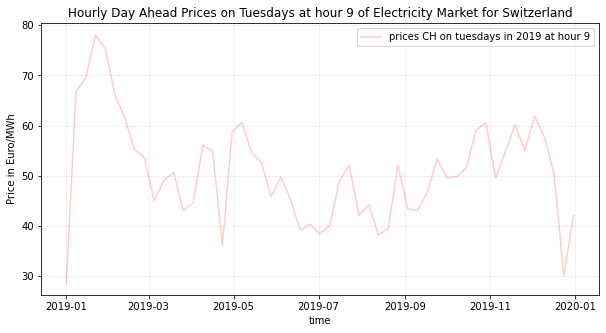

In [4]:
#get prices on tuesdays 2019
a_index = pd.date_range('2019-01-01', periods=53, freq='W-TUE')
a_priceH9 = epex_df[epex_df['Delivery day'].isin(a_index)]['Hour9']
#get dates 
a_dates = epex_df['Delivery day'].loc[a_priceH9.index]

# and plot them
plt.figure(figsize=(10,5))
plt.plot(a_dates, a_priceH9,'r-', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('Price in Euro/MWh')
plt.legend(['prices CH on tuesdays in 2019 at hour 9'],loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('Hourly Day Ahead Prices on Tuesdays at hour 9 of Electricity Market for Switzerland')

## 1.2. Reading entso-e transparency data from transparency plattform <br>
The data get be downloaded under following link: https://transparency.entsoe.eu/dashboard/show
We are going to read in following data:
- price data from 2019 and 2020 (till today) for CH and D Market (hourly) <br>
- Load Forecast (hourly) for CH, Germany (is 1/4-hourly), F and IT <br>
- Generation Forecast for CH, Germany, F and IT (conventional and renewable [Wind Onshore / Wind Offshore / Solar] separatly) <br>
- Transmission Capacity Forecast CH to neighboring countries: D, F, AU, IT (hourly) <br>
  



## <u>Important: a global Index for Start and End of Data is set here</u> 
It is necessary to define in what time intervall we are going to use read in data <br>
We could use the data over the whole intervall all the time <u>but</u> eventually conditions are changeing and we want to select a later or a shorter range of data. <br>
Therefore we want to create the time intervall flexible.<br>

So we define following global variables:
### the_start_date    : 'YYYY-MM-DD', is the date where we declare the data starts and time series will be created from that date on.
### the_up2date_date  : 'YYYY-MM-DD', is the date where time series will end
### the_up2date_index_h     : an index to select data in hourly manner (from start- to up2date date)
### the_up2date_index_15Min : an index to select data in quarter-hourly manner (from start- to up2date date)

In [5]:
#data starting from ..
the_start_date = '2019-01-01'
#last date loading data
the_up2date_date = '2020-10-15'

# create up2date_range index (for making sure to choose the right values)
the_up2date_index_h = pd.date_range(the_start_date,the_up2date_date, freq = 'h', closed = 'left')
the_up2date_index_15Min = pd.date_range(the_start_date,the_up2date_date, freq = '15Min', closed = 'left')

### 1.2.1 read Market Price Data (Day Ahead Market) for Switzerland and Germany
The read-in is done after manual download at https://transparency.entsoe.eu/transmission-domain/r2/dayAheadPrices/ and storing in local place<br>
Al read-in is done similarly. 
1. define Input Parameters: filename, time column name, value column name and a new name
2. read and parse files
3. concate to one serie (from start to up2date date)
4. find data/indexes where *Not a Value* or *Not a Number* is found

**<u>Important: <u> *Not a Number* won't be ereased in the data but just shown that and where they are!**

In [6]:
## ----------- LOADING CH PRICE DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)

a_file1 = './Data_V2/Day-ahead Prices_201901010000-202001010000_CH.csv'
a_file2 = './Data_V2/Day-ahead Prices_202001010000-202101010000_CH.csv'
a_time_col = 'MTU (UTC)'
a_value_col = 'Day-ahead Price [EUR/MWh]'
a_new_name = 'Day Ahead Prices CH'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
#a_priceCH = pd.Series([df_pricesD['Day-ahead Price [EUR/MWh]'].values, ], index = df_pricesD["MTU (UTC)"], 
#                 dtype = np.float64, name = 'Day Ahead Prices D' )

ts_pricesCH=ts_concat

In [7]:
## ----------- LOADING D PRICE DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 29.09.2020 -> means valid data till 28.09.2020)
a_file1 = './Data_V2/Day-ahead Prices_201901010000-202001010000_D.csv'
a_file2 = './Data_V2/Day-ahead Prices_202001010000-202101010000_D.csv'
a_time_col = 'MTU (UTC)'
a_value_col = 'Day-ahead Price [EUR/MWh]'
a_new_name = 'Day Ahead Prices D'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_pricesD=ts_concat

**Plot the prices just to see if everything looks consistent..**

Text(0.5, 1.0, 'Hourly Day Ahead Prices Electricity Market for Switzerland and Germany')

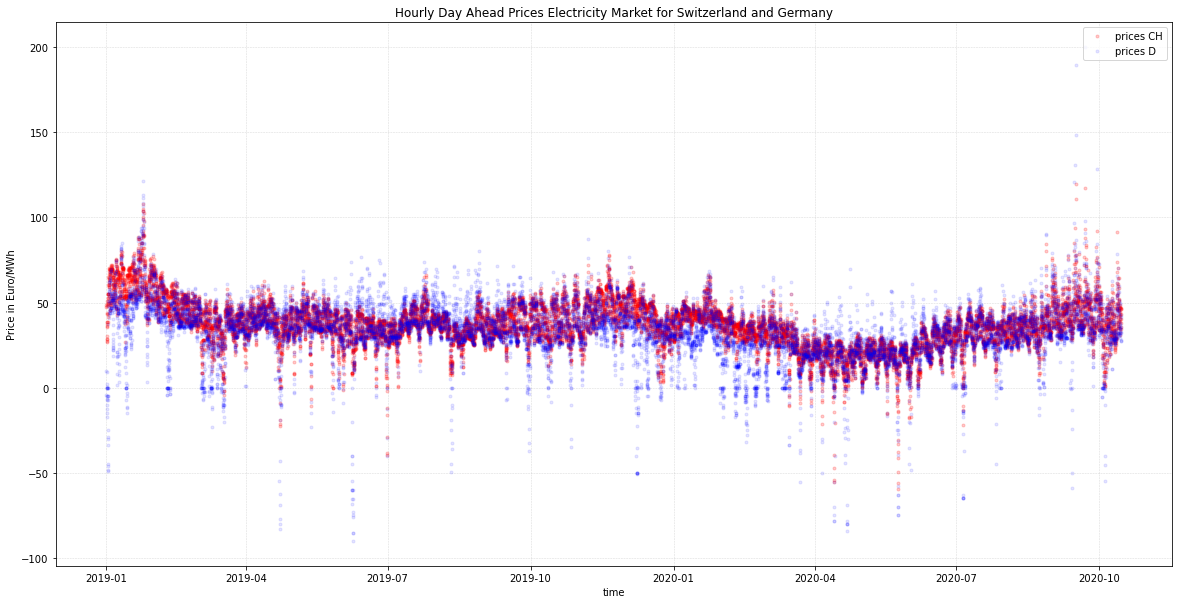

In [8]:
plt.figure(figsize = (20,10))
plt.plot(ts_pricesCH.index, ts_pricesCH.values,'r.', alpha = 0.2)
plt.plot(ts_pricesD.index, ts_pricesD.values,'b.', alpha = 0.1)
plt.xlabel('time')
plt.ylabel('Price in Euro/MWh')
plt.legend(['prices CH', 'prices D'],loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('Hourly Day Ahead Prices Electricity Market for Switzerland and Germany')

**use another plot and resample time serie and showing the Base Price of each day (Mean of all hours a day) ..**

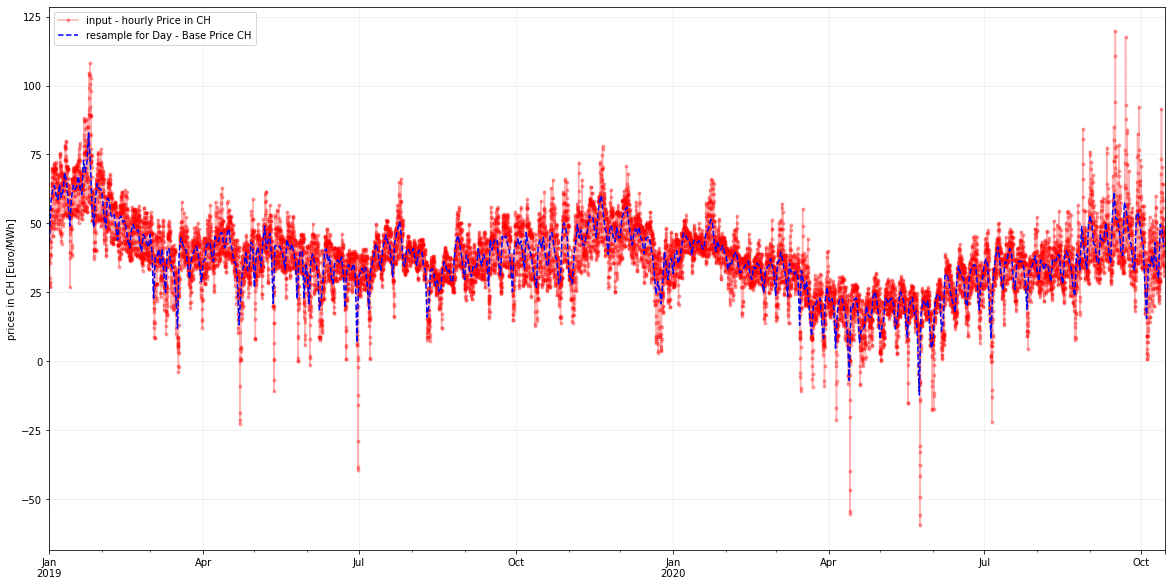

In [9]:
#use a placeholder just to quickly change between CH and D prices
#this kind of plot works only if numbers -> we have to drop NaNs
a_ts = ts_pricesCH.dropna()

plt.figure(figsize = (20,10))
a_ts.plot( alpha = 0.3,  style = 'r.-' )
a_ts.resample('D').mean().plot(alpha = 1.0, style = 'b--')
plt.legend(['input - hourly Price in CH', 'resample for Day - Base Price CH'],loc='upper left')
plt.ylabel('prices in CH [Euro/MWh]')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

**doing another Consistency check if the number of hours per month is correct** <br>

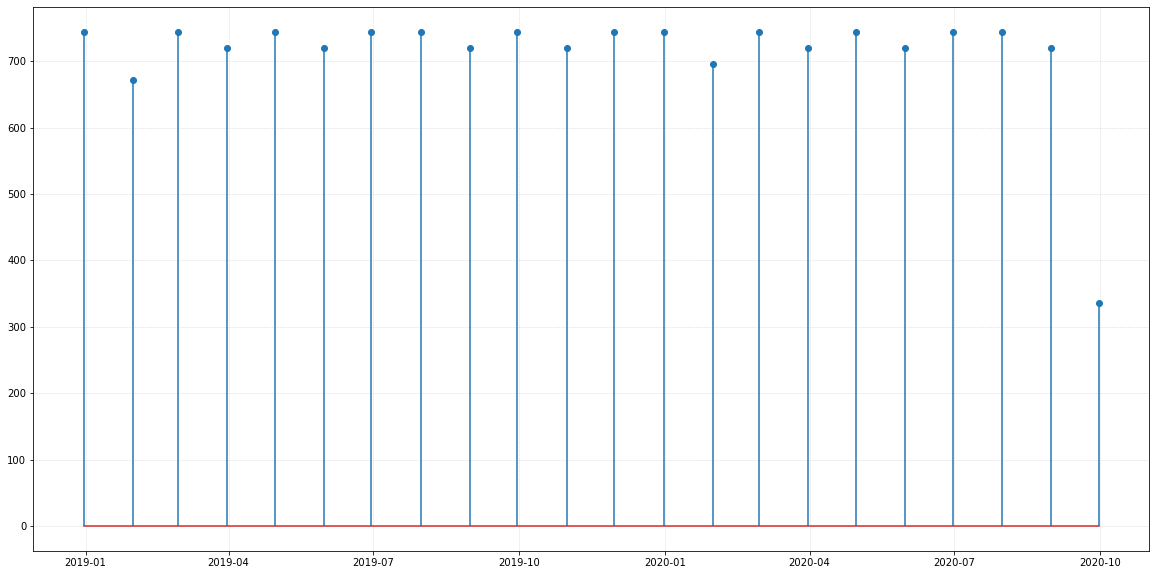

In [10]:
a_ts = ts_pricesCH.resample('M', label = 'left' ).count()
plt.figure(figsize = (20,10))
plt.stem(a_ts.index, a_ts.values, use_line_collection = True, bottom = 0.0)
#plt.xlim(pd.to_datetime('2019-01-10'), pd.to_datetime('2020-09-15'))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)


**last month always in doubt.. ;-)**

### now loading Load, Generation, Renewable forecast for CH, D, F and IT North

### 1.2.2. now loading driver data Country-wise, starting with <u>Switzerland</u>
Loading the driver data in same way as price data (see further up for common procedure).<br>
Loading following data:<br>
-> consumption/load <br>
-> conventional generation <br>
-> renewables generation


In [11]:
## ----------- LOADING CH LOAD DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Total Load - Day Ahead _ Actual_201901010000-202001010000_CH.csv'
a_file2 = './Data_V2/Total Load - Day Ahead _ Actual_202001010000-202101010000_CH.csv'
a_time_col = 'Time (UTC)'
a_value_col = 'Day-ahead Total Load Forecast [MW] - BZN|CH'
a_new_name = 'Load Day-ahead Forecast CH'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_LoadCH = ts_concat

!!!!!!!!!!!!!!  There are NaNs in :  Load Day-ahead Forecast CH !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2020-10-14 22:00:00', '2020-10-14 23:00:00'], dtype='datetime64[ns]', freq='H')


In [12]:
## ----------- LOADING CH GENERATION DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecast - Day ahead_201901010000-202001010000_CH.csv'
a_file2 = './Data_V2/Generation Forecast - Day ahead_202001010000-202101010000_CH.csv'
a_time_col = 'MTU'
a_value_col = 'Scheduled Generation [MW] (D) - BZN|CH'
a_new_name = 'Generation Day-ahead Forecast CH'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_GenCH = ts_concat

In [13]:
## ----------- LOADING CH RENEWABLE GENERATION DATA  -> reading in Solar and On-Shore Wind
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecasts for Wind and Solar_201901010000-202001010000_CH.csv'
a_file2 = './Data_V2/Generation Forecasts for Wind and Solar_202001010000-202101010000_CH.csv'
a_time_col = 'MTU (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

# do the concatenation for Solar
a_value_col = 'Generation - Solar  [MW] Day Ahead/ BZN|CH'
a_new_name = 'Solar Generation Day-ahead Forecast CH'
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenSolarCH = ts_concat
    
    
# do the concatenation for Wind On-Shore
a_value_col = 'Generation - Wind Onshore  [MW] Day Ahead/ BZN|CH'    
a_new_name = 'Wind Generation Day-ahead Forecast CH' 
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenWindCH = ts_concat    

### 1.2.3. now loading <u>Germany</u> <br>
-> Consumption/load <br>
-> conventional generation <br>
-> renewables Generation<br>
**<u>Important to notice:</u> Load and renewable Generation is formatted in 1/4h (unlike the other time series which are in hourly bins) !**<br>
As a consequence these time series have to be adapted by resample when used (for fit and correlation)!

In [14]:
## ----------- LOADING D LOAD DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Total Load - Day Ahead _ Actual_201901010000-202001010000_corr_D.csv'  # <- this file corrected "by hand" because of NaN Values in a day!!!
a_file2 = './Data_V2/Total Load - Day Ahead _ Actual_202001010000-202101010000_D.csv'
a_time_col = 'Time (UTC)'
a_value_col = 'Day-ahead Total Load Forecast [MW] - BZN|DE-LU'
a_new_name = 'Load Day-ahead Forecast D'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_15Min] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_LoadD = ts_concat

In [15]:
## ----------- LOADING D GENERATION DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecast - Day ahead_201901010000-202001010000_D.csv'
a_file2 = './Data_V2/Generation Forecast - Day ahead_202001010000-202101010000_D.csv'
a_time_col = 'MTU'
a_value_col = 'Scheduled Generation [MW] (D) - BZN|DE-LU'
a_new_name = 'Generation Day-ahead Forecast D'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_GenD = ts_concat

!!!!!!!!!!!!!!  There are NaNs in :  Generation Day-ahead Forecast D !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2020-10-08 22:00:00', '2020-10-08 23:00:00',
               '2020-10-09 00:00:00', '2020-10-09 01:00:00',
               '2020-10-09 02:00:00', '2020-10-09 03:00:00',
               '2020-10-09 04:00:00', '2020-10-09 05:00:00',
               '2020-10-09 06:00:00', '2020-10-09 07:00:00',
               ...
               '2020-10-14 14:00:00', '2020-10-14 15:00:00',
               '2020-10-14 16:00:00', '2020-10-14 17:00:00',
               '2020-10-14 18:00:00', '2020-10-14 19:00:00',
               '2020-10-14 20:00:00', '2020-10-14 21:00:00',
               '2020-10-14 22:00:00', '2020-10-14 23:00:00'],
              dtype='datetime64[ns]', length=146, freq='H')


In [16]:
## ----------- LOADING D RENEWABLE GENERATION DATA  -> reading in Solar, On-Shore Wind and Off-Shore Wind
## be aware that this data is 1/4 hourly based!!
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecasts for Wind and Solar_201901010000-202001010000_D.csv'
a_file2 = './Data_V2/Generation Forecasts for Wind and Solar_202001010000-202101010000_D.csv'
a_time_col = 'MTU (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

# do the concatenation for Solar
a_value_col = 'Generation - Solar  [MW] Day Ahead/ BZN|DE-LU'
a_new_name = 'Solar Generation Day-ahead Forecast D'
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_15Min] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenSolarD = ts_concat
    
    
# do the concatenation for Wind On-Shore
a_value_col = 'Generation - Wind Onshore  [MW] Day Ahead/ BZN|DE-LU'    
a_new_name = 'On-Shore Wind Generation Day-ahead Forecast D' 
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_15Min] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenOnWindD = ts_concat   


# do the concatenation for Wind Off-Shore
a_value_col = 'Generation - Wind Offshore  [MW] Day Ahead/ BZN|DE-LU'    
a_new_name = 'Off-Shore Wind Generation Day-ahead Forecast D' 
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_15Min] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenOffWindD = ts_concat   

!!!!!!!!!!!!!!  There are NaNs in :  Solar Generation Day-ahead Forecast D !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2020-07-14 22:00:00', '2020-07-14 22:15:00',
               '2020-07-14 22:30:00', '2020-07-14 22:45:00',
               '2020-07-14 23:00:00', '2020-07-14 23:15:00',
               '2020-07-14 23:30:00', '2020-07-14 23:45:00',
               '2020-07-15 00:00:00', '2020-07-15 00:15:00',
               ...
               '2020-09-10 19:30:00', '2020-09-10 19:45:00',
               '2020-09-10 20:00:00', '2020-09-10 20:15:00',
               '2020-09-10 20:30:00', '2020-09-10 20:45:00',
               '2020-09-10 21:00:00', '2020-09-10 21:15:00',
               '2020-09-10 21:30:00', '2020-09-10 21:45:00'],
              dtype='datetime64[ns]', length=184, freq=None)
!!!!!!!!!!!!!!  There are NaNs in :  On-Shore Wind Generation Day-ahead Forecast D !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2020-07-14 22:00:00', '2020-0

### 1.2.4. now loading <u>France </u>

-> Consumption/load <br>
-> conventional generation <br>
-> renewables Generation<br>

In [17]:
## ----------- LOADING F LOAD DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Total Load - Day Ahead _ Actual_201901010000-202001010000_F.csv'
a_file2 = './Data_V2/Total Load - Day Ahead _ Actual_202001010000-202101010000_F.csv'
a_time_col = 'Time (UTC)'
a_value_col = 'Day-ahead Total Load Forecast [MW] - BZN|FR'
a_new_name = 'Load Day-ahead Forecast F'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_LoadF = ts_concat

In [18]:
## ----------- LOADING F GENERATION DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecast - Day ahead_201901010000-202001010000_F.csv'
a_file2 = './Data_V2/Generation Forecast - Day ahead_202001010000-202101010000_F.csv'
a_time_col = 'MTU'
a_value_col = 'Scheduled Generation [MW] (D) - BZN|FR'
a_new_name = 'Generation Day-ahead Forecast F'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_GenF = ts_concat  

!!!!!!!!!!!!!!  There are NaNs in :  Generation Day-ahead Forecast F !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2019-02-17 23:00:00', '2019-02-18 00:00:00',
               '2019-02-18 01:00:00', '2019-02-18 02:00:00',
               '2019-02-18 03:00:00', '2019-02-18 04:00:00',
               '2019-02-18 05:00:00', '2019-02-18 06:00:00',
               '2019-02-18 07:00:00', '2019-02-18 08:00:00',
               '2019-02-18 09:00:00', '2019-02-18 10:00:00',
               '2019-02-18 11:00:00', '2019-02-18 12:00:00',
               '2019-02-18 13:00:00', '2019-02-18 14:00:00',
               '2019-02-18 15:00:00', '2019-02-18 16:00:00',
               '2019-02-18 17:00:00', '2019-02-18 18:00:00',
               '2019-02-18 19:00:00', '2019-02-18 20:00:00',
               '2019-02-18 21:00:00', '2019-02-18 22:00:00'],
              dtype='datetime64[ns]', freq='H')


In [19]:
## ----------- LOADING F RENEWABLE GENERATION DATA  -> reading in Solar and On-Shore Wind
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecasts for Wind and Solar_201901010000-202001010000_F.csv'
a_file2 = './Data_V2/Generation Forecasts for Wind and Solar_202001010000-202101010000_F.csv'
a_time_col = 'MTU (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

# do the concatenation for Solar
a_value_col = 'Generation - Solar  [MW] Day Ahead/ BZN|FR'
a_new_name = 'Solar Generation Day-ahead Forecast F'
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenSolarF = ts_concat
    
    
# do the concatenation for Wind On-Shore
a_value_col = 'Generation - Wind Onshore  [MW] Day Ahead/ BZN|FR'    
a_new_name = 'Wind Generation Day-ahead Forecast F' 
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenWindF = ts_concat    

!!!!!!!!!!!!!!  There are NaNs in :  Solar Generation Day-ahead Forecast F !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2019-02-04 23:00:00', '2019-02-05 00:00:00',
               '2019-02-05 01:00:00', '2019-02-05 02:00:00',
               '2019-02-05 03:00:00', '2019-02-05 04:00:00',
               '2019-02-05 05:00:00', '2019-02-05 06:00:00',
               '2019-02-05 07:00:00', '2019-02-05 08:00:00',
               ...
               '2020-07-13 12:00:00', '2020-07-13 13:00:00',
               '2020-07-13 14:00:00', '2020-07-13 15:00:00',
               '2020-07-13 16:00:00', '2020-07-13 17:00:00',
               '2020-07-13 18:00:00', '2020-07-13 19:00:00',
               '2020-07-13 20:00:00', '2020-07-13 21:00:00'],
              dtype='datetime64[ns]', length=121, freq=None)
!!!!!!!!!!!!!!  There are NaNs in :  Wind Generation Day-ahead Forecast F !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2019-07-24 01:00:00', '2019-07-24 02:0

### 1.2.5. now loading <u>Italy</u>

-> Consumption/load <br>
-> conventional generation <br>
-> renewables Generation<br>
**<u>Important:<u> Italy has several bidding zones, only North is loaded in a first approach.** <br>
Background&reason: Switzerland only has direct electricity exchange with this zone from.

In [20]:
## ----------- LOADING IT LOAD DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Total Load - Day Ahead _ Actual_201901010000-202001010000_IT_North.csv'
a_file2 = './Data_V2/Total Load - Day Ahead _ Actual_202001010000-202101010000_IT_North.csv'
a_time_col = 'Time (UTC)'
a_value_col = 'Day-ahead Total Load Forecast [MW] - BZN|IT-North'
a_new_name = 'Load Day-ahead Forecast IT North'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')
#make to Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_LoadIT = ts_concat

In [21]:
## ----------- LOADING IT North GENERATION DATA
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecast - Day ahead_201901010000-202001010000_IT_North.csv'
a_file2 = './Data_V2/Generation Forecast - Day ahead_202001010000-202101010000_IT_North.csv'
a_time_col = 'MTU'
a_value_col = 'Scheduled Generation [MW] (D) - BZN|IT-North'
a_new_name = 'Generation Day-ahead Forecast IT'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_GenIT = ts_concat

In [22]:
## ----------- LOADING IT North RENEWABLE GENERATION DATA  -> reading in Solar and On-Shore Wind
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Generation Forecasts for Wind and Solar_201901010000-202001010000_IT_North.csv'
a_file2 = './Data_V2/Generation Forecasts for Wind and Solar_202001010000-202101010000_IT_North.csv'
a_time_col = 'MTU (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

# do the concatenation for Solar
a_value_col = 'Generation - Solar  [MW] Day Ahead/ BZN|IT-North'
a_new_name = 'Solar Generation Day-ahead Forecast IT North'
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenSolarIT = ts_concat
    
    
# do the concatenation for Wind On-Shore
a_value_col = 'Generation - Wind Onshore  [MW] Day Ahead/ BZN|IT-North'    
a_new_name = 'Wind Generation Day-ahead Forecast IT North' 
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_RenGenWindIT = ts_concat    

!!!!!!!!!!!!!!  There are NaNs in :  Solar Generation Day-ahead Forecast IT North !!!!!!!!!!!!!!!
following indexes to be aware of  :
 DatetimeIndex(['2019-06-24 22:00:00', '2019-06-24 23:00:00',
               '2019-06-25 00:00:00', '2019-06-25 01:00:00',
               '2019-06-25 02:00:00', '2019-06-25 03:00:00',
               '2019-06-25 04:00:00', '2019-06-25 05:00:00',
               '2019-06-25 06:00:00', '2019-06-25 07:00:00',
               ...
               '2020-09-29 12:00:00', '2020-09-29 13:00:00',
               '2020-09-29 14:00:00', '2020-09-29 15:00:00',
               '2020-09-29 16:00:00', '2020-09-29 17:00:00',
               '2020-09-29 18:00:00', '2020-09-29 19:00:00',
               '2020-09-29 20:00:00', '2020-09-29 21:00:00'],
              dtype='datetime64[ns]', length=912, freq=None)


### 1.2.6. now loading <u>Transmission Capacities</u> to IT, F, D and AT (always both directions in one file)

In [23]:
## ----------- LOADING day ahead Transmission forecast for CH <-> IT 
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_201901010000-202001010000_CH-IT.csv'
a_file2 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_202001010000-202101010000_CH-IT.csv'
a_time_col = 'Time (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

#load Direction CH-IT
a_value_col = 'BZN|CH > BZN|IT-North [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast CH-IT'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransCH_IT = ts_concat


#load Direction IT-CH
a_value_col = 'BZN|CH > BZN|IT-North [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast IT-CH'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransIT_CH = ts_concat

In [24]:
## ----------- LOADING day ahead Transmission forecast for CH <-> F 
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_201901010000-202001010000_CH-F.csv'
a_file2 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_202001010000-202101010000_CH-F.csv'
a_time_col = 'Time (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

#load Direction CH-F
a_value_col = 'BZN|CH > BZN|FR [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast CH-F'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransCH_F = ts_concat


#load Direction F-CH
a_value_col = 'BZN|FR > BZN|CH [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast F-CH'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransF_CH = ts_concat

In [25]:
## ----------- LOADING day ahead Transmission forecast for CH <-> D 
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_201901010000-202001010000_CH-D.csv'
a_file2 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_202001010000-202101010000_CH-D.csv'
a_time_col = 'Time (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

#load Direction CH-D
a_value_col = 'BZN|CH > BZN|DE-LU [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast CH-D'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransCH_D = ts_concat


#load Direction D-CH
a_value_col = 'BZN|DE-LU > BZN|CH [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast D-CH'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransD_CH = ts_concat

In [26]:
## ----------- LOADING day ahead Transmission forecast for CH <-> AT 
#loading all 2019 and 2020 up until now.. (last downloaded: 15.10.2020 -> means valid data till 14.10.2020)
a_file1 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_201901010000-202001010000_CH-AT.csv'
a_file2 = './Data_V2/Forecasted Transfer Capacities - Day Ahead_202001010000-202101010000_CH-AT.csv'
a_time_col = 'Time (UTC)'

a_dateparse = lambda x: datetime.strptime( x[0:16], '%d.%m.%Y %H:%M')

#load Direction CH-AT
a_value_col = 'BZN|CH > BZN|AT [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast CH-AT'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransCH_AT = ts_concat


#load Direction AT-CH
a_value_col = 'BZN|AT > BZN|CH [MW]'
a_new_name = 'Transmission Capacity Day-ahead Forecast AT-CH'
#make the Series ..
df_1 = pd.read_csv(a_file1, parse_dates=[a_time_col], date_parser=a_dateparse )
S_1 = pd.Series(df_1[a_value_col].values, index = df_1[a_time_col], name = a_new_name)
df_2 = pd.read_csv(a_file2, parse_dates=[a_time_col], date_parser=a_dateparse )
S_2 = pd.Series(df_2[a_value_col].values, index = df_2[a_time_col], name = a_new_name)

#append the the one to the other
ts_concat = pd.to_numeric( pd.concat([S_1, S_2], verify_integrity = True)[the_up2date_index_h] )
#check if there are nan values ..
if ts_concat.hasnans:
    print('!!!!!!!!!!!!!!  There are NaNs in : ', a_new_name , '!!!!!!!!!!!!!!!' )
    print('following indexes to be aware of  :\n', ts_concat.index[ts_concat.isna()])
    
ts_TransAT_CH = ts_concat

### 1.2.7. Result - time Series now loaded are: <br>
Time series are all loaded in UTC time Format. This should be corrected in CET to compare with other time series, i.e. if compared to swissgrid or EPEX <br>

**Name**   &emsp; &emsp; &emsp;&emsp; &emsp;  **Descritpion** <br>
ts_pricesCH (h) &emsp; : Day Ahead Prices in Switzerland <br>
ts_pricesD (h) &emsp; : Day Ahead Prices in Germany<br>
****** <br>
ts_LoadCH (h) &emsp; : Load forecast in Switzerland<br>
ts_LoadD (1/4-h) &emsp; : Load forecast in Germany<br>
ts_LoadF (h) &emsp; : Load forecast in France<br>
ts_LoadIT(h) &emsp; : Load forecast in Italy <u>only Zone North</u><br>
****** <br>
ts_GenCH (h) &emsp; : Generation forecast in Switzerland<br>
ts_RenGenSolarCH (h) &emsp; : Renewable Solar Generation forecast in Switzerland<br>
ts_RenGenWindCH (h) &emsp; : Renewable Wind Generation forecast in Switzerland<br>
---- <br>
ts_GenD (h) &emsp; : Generation forecast in Germany<br>
ts_RenGenSolarD (1/4-h) &emsp; : Renewable Solar Generation forecast in Germany<br>
ts_RenGenOffWindD (1/4-h) &emsp; : Renewable Off-Shore Wind Generation forecast in Germany<br>
ts_RenGenOnWindD (1/4-h) &emsp; : Renewable On-Shore Wind Generation forecast in Germany<br>
---- <br>
ts_GenF (h) &emsp; : Generation forecast in France<br>
ts_RenGenSolarF (h) &emsp; : Renewable Solar Generation forecast in France<br>
ts_RenGenWindF (h) &emsp; : Renewable Wind Generation forecast in France<br>
---- <br>
ts_GenIT (h) &emsp; : Generation forecast in Italy <u>only Zone North</u><br>
ts_RenGenSolarIT (h) &emsp; : Renewable Solar Generation forecast in Italy <u>only Zone North</u><br>
ts_RenGenWindIT (h) &emsp; : Renewable Wind Generation forecast in Italy <u>only Zone North</u><br>
<br>
ts_TransCH_D &emsp; : Transmission forecast in CH -> Germany<br>
ts_TransD_CH &emsp; : Transmission forecast in Germany -> CH<br>
ts_TransCH_F &emsp; : Transmission forecast in CH -> France<br>
ts_TransF_CH &emsp; : Transmission forecast in France -> CH<br>
ts_TransCH_AT &emsp; : Transmission forecast in CH -> Austria<br>
ts_TransAT_CH &emsp; : Transmission forecast in Austria -> CH<br>
ts_TransCH_IT &emsp; : Transmission forecast in CH -> Italy<br>
ts_TransIT_CH &emsp; : Transmission forecast in Italy -> CH<br>


## 1.3. Consistency Checks and Overview 

Now we do some overview and consistency checks with the loaded data. <br>
- see at the consumption versus generation for CH and D in plots
- see at the overall numbers over the Year 2019
- compare EPEX with transparency - comparing Market Price Data
- examine Price distribution overall
- examine hourly price distribution

**Important: a global Index already defined further above .. will be used here** <br>
<u>Reminder:</u> following the global indexes:  <br>
the_start_date   : 'YYYY-MM-DD' <br>
the_up2date_date : 'YYYY-MM-DD' <br>
the_up2date_index_h     : selecting data in hourly manner <br>
the_up2date_index_15Min : selecting data in quarter-hourly manner<br>

In [27]:
# create a date_range index for making sure to choose the right values for next plots
# make it configurable, use concrete date (instead of globals) ..
a_data_start = the_start_date #i.e. '2019-01-01'
a_data_end = the_up2date_date #i.e. '2020-09-28'
an_selection_index_h = pd.date_range(a_data_start,a_data_end, freq = 'h', closed = 'left')
an_selection_index_15Min = pd.date_range(a_data_start,a_data_end, freq = '15Min', closed = 'left')

### 1.3.1. Load vs. Generation for CH and D in Plots 

<Figure size 432x288 with 0 Axes>

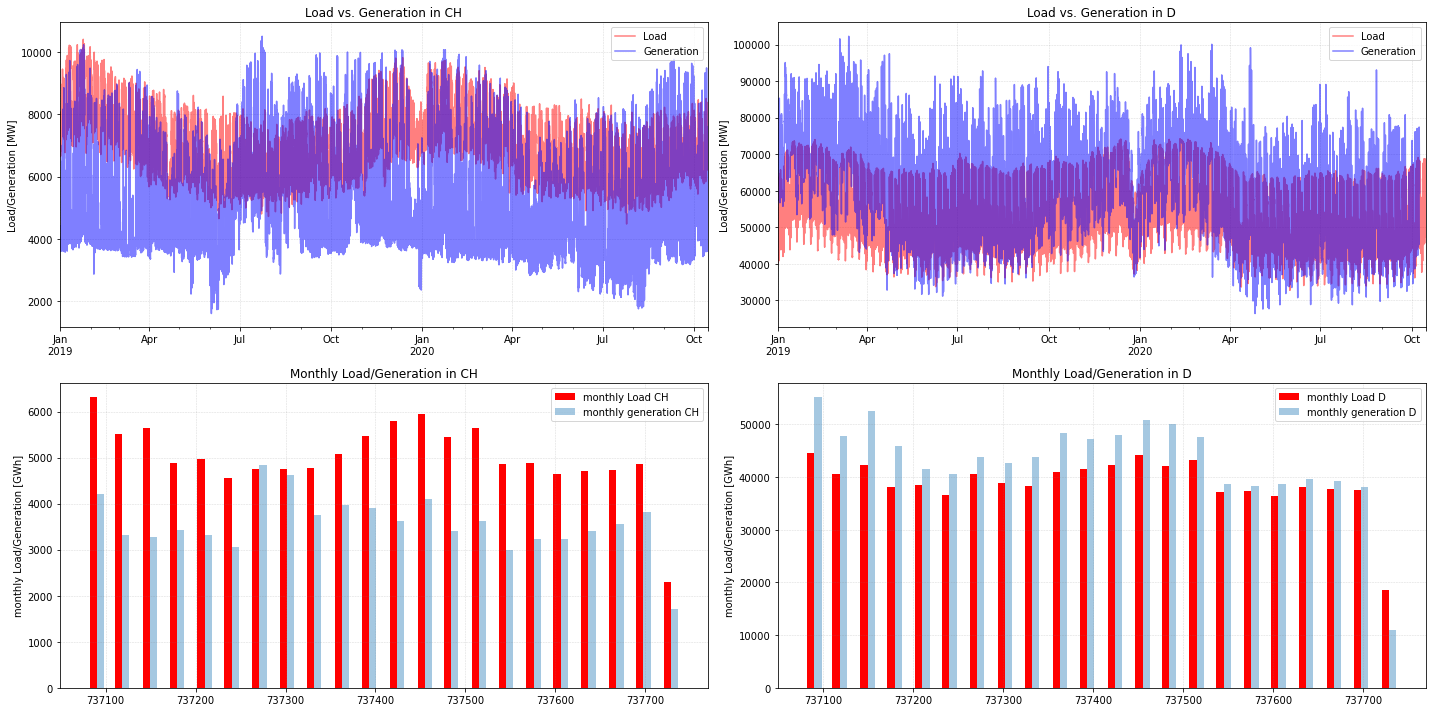

In [28]:
plt.figure()
fig, axes = plt.subplots(2,2, figsize=(20,10),  tight_layout=True)
a_font_size = 10
plt.subplot(221)
plt.title('Load vs. Generation in CH')
plt.ylabel('Load/Generation [MW]')
ts_LoadCH[an_selection_index_h].plot( alpha = 0.5,  style = 'r-' )
ts_GenCH[an_selection_index_h].plot(alpha = 0.5,  style = 'b-')
plt.legend(['Load', 'Generation'], loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
#plt.plot(ts_LoadCH.index.values, ts_LoadCH.values, 'r.')
plt.subplot(222)
plt.title('Load vs. Generation in D')
plt.ylabel('Load/Generation [MW]')
ts_LoadD[an_selection_index_15Min].resample('H').mean().plot( alpha = 0.5,  style = 'r-' )
ts_GenD[an_selection_index_h].resample('H').mean().plot(alpha = 0.5,  style = 'b-')
plt.legend(['Load', 'Generation'], loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.subplot(223)
plt.title('Monthly Load/Generation in CH')
plt.ylabel('monthly Load/Generation [GWh]')
a_tsL = ts_LoadCH[an_selection_index_h].resample('M').sum()
a_tsG = ts_GenCH[an_selection_index_h].resample('M').sum()
plt.bar(date2num(a_tsL.index.values) - 4.0, a_tsL.values/1000,  width = 8, label = 'monthly Load CH', color = 'r')
plt.bar(date2num(a_tsG.index.values) + 4.0, a_tsG.values/1000,  width = 8, alpha = 0.4, label = 'monthly generation CH')
plt.legend()
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.subplot(224)
plt.title('Monthly Load/Generation in D')
plt.ylabel('monthly Load/Generation [GWh]')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
a_tsL = ts_LoadD[an_selection_index_15Min].resample('H').mean().resample('M').sum()
a_tsG = ts_GenD[an_selection_index_h].resample('M').sum()
plt.bar(date2num(a_tsL.index.values) - 4.0, a_tsL.values/1000,  width = 8, label = 'monthly Load D', color = 'r')
plt.bar(date2num(a_tsG.index.values) + 4.0, a_tsG.values/1000,  width = 8, alpha = 0.4, label = 'monthly generation D')
plt.legend()

### 1.3.2. Overall numbers for Year 2019
**cross checks will only be done for Year 2019 (cause this data is available by other statistics)** <br>
calculate the yearly load and generation just to verify the numbers .. <br>
**Important:** As there are *only* forecasted time series (and not actual measured data) this will only be an "about-estimation".



In [29]:
# create a date_range index for making sure to choose the right values for next calculation
a_start = '2019-01-01'
an_end = '2020-01-01'
a_index_h = pd.date_range(a_start,an_end, freq = 'h', closed = 'left')
a_index_15Min = pd.date_range(a_start,an_end, freq = '15Min', closed = 'left')
print('Imported and resambled time Series in the date-range: ' + a_start + ' to ' + an_end + ' show following results: ')
print('yearly consumption in 2019 for switzerland was %2.2f' % (ts_LoadCH[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production  in 2019 for switzerland was %2.2f' % (ts_GenCH[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly consumption in 2019 for Germany was %2.2f' % (ts_LoadD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06), 'TWh')
print('yearly production  in 2019 for germany was %2.2f' % (ts_GenD[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly consumption in 2019 for France was %2.2f' % (ts_LoadF[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production  in 2019 for France was %2.2f' % (ts_GenF[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly consumption in 2019 for Italy Zone North was %2.2f' % (ts_LoadIT[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production  in 2019 for Italy Zone North was %2.2f' % (ts_GenIT[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('---------------------------------------------------')
print('Renewable Generation CH:')
print('yearly production Wind in 2019 was %2.2f' % (ts_RenGenWindCH[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production Solar in 2019 was %2.2f' % (ts_RenGenSolarCH[a_index_h].resample('Y').sum()/1e06), 'TWh')
a_wind = ts_RenGenWindCH[a_index_h].resample('Y').sum()/1e06
a_sol = ts_RenGenSolarCH[a_index_h].resample('Y').sum()/1e06
print('Total Wind&Solar in 2019 was %2.2f' % (a_wind + a_sol), 'TWh')
print('---------------------------------------------------')
print('Renewable Generation D:')
print('yearly production Wind Offshore in 2019 was %2.2f' % (ts_RenGenOffWindD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06), 'TWh')
print('yearly production Wind Onshore in 2019 was %2.2f' % (ts_RenGenOnWindD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06), 'TWh')
print('yearly production Solar in 2019 was %2.2f' % (ts_RenGenSolarD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06), 'TWh')
a_wind = ts_RenGenOffWindD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06 + ts_RenGenOnWindD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06
a_sol = ts_RenGenSolarD[a_index_15Min].resample('H').mean().resample('Y').sum()/1e06
print('Total Wind&Solar in 2019 was %2.2f' % (a_wind + a_sol), 'TWh')
print('---------------------------------------------------')
print('Renewable Generation F:')
print('yearly production Wind in 2019 was %2.2f' % (ts_RenGenWindF[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production Solar in 2019 was %2.2f' % (ts_RenGenSolarF[a_index_h].resample('Y').sum()/1e06), 'TWh')
a_wind = ts_RenGenWindF[a_index_h].resample('Y').sum()/1e06
a_sol = ts_RenGenSolarF[a_index_h].resample('Y').sum()/1e06
print('Total Wind&Solar in 2019 was %2.2f' % (a_wind + a_sol), 'TWh')
print('---------------------------------------------------')
print('Renewable Generation IT North:')
print('yearly production Wind in 2019 was %2.2f' % (ts_RenGenWindIT[a_index_h].resample('Y').sum()/1e06), 'TWh')
print('yearly production Solar in 2019 was %2.2f' % (ts_RenGenSolarIT[a_index_h].resample('Y').sum()/1e06), 'TWh')
a_wind = ts_RenGenWindIT[a_index_h].resample('Y').sum()/1e06
a_sol = ts_RenGenSolarIT[a_index_h].resample('Y').sum()/1e06
print('Total Wind&Solar in 2019 was %2.2f' % (a_wind + a_sol), 'TWh')

print('---------------------------------------------------')
print('Just for a short explanation: CH has a shortage in Generation compared to the Load.')
print('This can be explained by the Import from F, which is reserved for shares of CH companies for nuclear energy.')
print('The capacity reserved gives a rough estimate for nuclear energy imported and sums up to : %2.2f' % (ts_TransF_CH[a_index_h].resample('Y').sum()/1e06), 'TWh')

Imported and resambled time Series in the date-range: 2019-01-01 to 2020-01-01 show following results: 
yearly consumption in 2019 for switzerland was 62.51 TWh
yearly production  in 2019 for switzerland was 45.31 TWh
yearly consumption in 2019 for Germany was 483.54 TWh
yearly production  in 2019 for germany was 557.38 TWh
yearly consumption in 2019 for France was 468.48 TWh
yearly production  in 2019 for France was 535.22 TWh
yearly consumption in 2019 for Italy Zone North was 166.11 TWh
yearly production  in 2019 for Italy Zone North was 108.26 TWh
---------------------------------------------------
Renewable Generation CH:
yearly production Wind in 2019 was 0.05 TWh
yearly production Solar in 2019 was 0.45 TWh
Total Wind&Solar in 2019 was 0.50 TWh
---------------------------------------------------
Renewable Generation D:
yearly production Wind Offshore in 2019 was 24.60 TWh
yearly production Wind Onshore in 2019 was 98.38 TWh
yearly production Solar in 2019 was 41.57 TWh
Total Win

### 1.3.3. compare EPEX with transparency - comparing Market Price Data
We want to check the consistency only for a sample assuming that for the others it then will be ok.<br>
We're gona to index only a certain hour.<br>
As an example we take Tuesdays hour number 9 and 10<br> 
Reflecting that we loaded the time series in UTC, we have to convert these to CET (-> +2h) still to compare and make test with time series of other data provider.<br>
**Note that** EPEX Prices for Year 2019 loaded in dataframe at the beginning of the notebook in data frame "epex_df" ..

Get EPEX Data

In [30]:
#get prices on tuesdays 2019
a_indexE = pd.date_range('2019-01-01', periods=53, freq='W-TUE')
#find the rows by date and sort the output by date again -> cause "isin()" inverts the order ...
a_priceH9E = epex_df[epex_df['Delivery day'].isin(a_indexE)].sort_values(by=['Delivery day'])['Hour9']

#get dates 
a_datesE = epex_df['Delivery day'].loc[a_priceH9E.index]

Get transparency data

In [31]:
#our Series do not have any time zone defintion -> to localize them as time zone "UTC"
a_ts = ts_pricesCH.tz_localize('UTC')
a_ts.tz_convert('Europe/Berlin')
#define index -> here must be with time zone cause a_ts is defined with time zone (see further up..)
a_indexT = pd.date_range('2019-01-01 08:00:00', periods=53, freq='W-TUE', tz = 'Europe/Berlin')
a_priceH9T = a_ts[a_indexT]

.. plot

Text(0.5, 1.0, 'Hourly Day Ahead Prices on Tuesdays at hour 9 of Electricity Market for Switzerland')

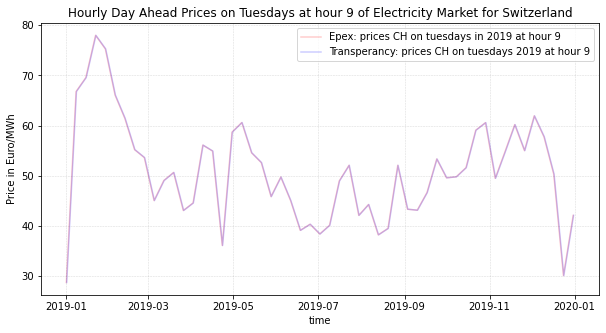

In [32]:
# and plot them both
plt.figure(figsize=(10,5))
plt.plot(a_datesE, a_priceH9E,'r-', alpha = 0.2)
plt.plot(a_indexT, a_priceH9T,'b-', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('Price in Euro/MWh')
plt.legend(['Epex: prices CH on tuesdays in 2019 at hour 9', 'Transperancy: prices CH on tuesdays 2019 at hour 9'],loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('Hourly Day Ahead Prices on Tuesdays at hour 9 of Electricity Market for Switzerland')

**<u>result:</u>** consistent (there is one curve visible means red and blue overlaying)!

In [33]:
#Just doing the check for another hour -> ..
#get prices on tuesdays 2019
a_indexE = pd.date_range('2019-01-01', periods=53, freq='W-SUN')
#find the rows by date and sort the output by date again -> cause "isin()" inverts the order ...
a_priceH10E = epex_df[epex_df['Delivery day'].isin(a_indexE)].sort_values(by=['Delivery day'])['Hour10']
#get dates 
a_datesE = epex_df['Delivery day'].loc[a_priceH10E.index]

In [34]:
#define index -> here must be with time zone cause a_ts is defined with time zone (see further up..)
a_indexT = pd.date_range('2019-01-01 09:00:00', periods=53, freq='W-SUN', tz = 'Europe/Berlin')
a_priceH10T = a_ts[a_indexT]

Text(0.5, 1.0, 'Hourly Day Ahead Prices on Sundays at hour 10 of Electricity Market for Switzerland')

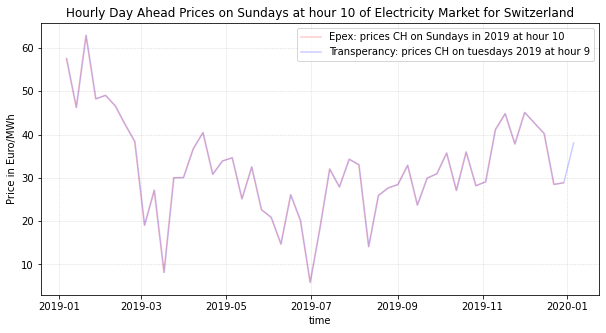

In [35]:
# and plot them both
plt.figure(figsize=(10,5))
plt.plot(a_datesE, a_priceH10E,'r-', alpha = 0.2)
plt.plot(a_indexT, a_priceH10T,'b-', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('Price in Euro/MWh')
plt.legend(['Epex: prices CH on Sundays in 2019 at hour 10', 'Transperancy: prices CH on tuesdays 2019 at hour 9'],loc='upper right')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('Hourly Day Ahead Prices on Sundays at hour 10 of Electricity Market for Switzerland')

## 2. Examining Data

### 2.1. Price distribution <br>
.. doing that for a defineable data range in following general procedure:  <br>
1) preparing indexes <br>
2) look at distribution (overall and seasonal-/product-wise ) <br>
3) making box plots of 24h - hourly price distribution (seasonal-/product-wise )<br>

#### Preparing indexes
As we want to examine the data for seasonality and product we create indexes for this.<br>
Seasonality means:
1. Summer time - April to September
2. Winter time - October to March
<br>

Product means:
1. peak time - thats the time of working hours Monday to Friday, hour 8 to hour 20
2. off-peak time - that means the complement of peak hours (incl. weekend hours)

In [36]:
# create a date_range index (for making sure to choose the right values) -> use local a_data_start, a_data_end defined at the beginning of 1.3
#an_index4Presentation = pd.date_range('2019-01-01','2020-01-01', freq = 'h', closed = 'left') #<-only for 2019
an_index4Presentation = pd.date_range(a_data_start,a_data_end, freq = 'h', closed = 'left')

In [37]:
#create a data range for winter, taking into account that 2019 and 2020 is in focus
an_index_Q1_19 = pd.date_range('2019-01-01','2019-04-01', freq = 'h', closed = 'left')
an_index_Q4_19 = pd.date_range('2019-10-01','2020-01-01', freq = 'h', closed = 'left')
an_index_Q1_20 = pd.date_range('2020-01-01','2020-04-01', freq = 'h', closed = 'left')
an_index_Q4_20 = pd.date_range('2020-10-01','2021-01-01', freq = 'h', closed = 'left')
#append the indexes ..  
an_app_index_Q1Q4 = an_index_Q1_19.append(an_index_Q4_19).append(an_index_Q1_20).append(an_index_Q4_20)
#only take the values which are in the data range
an_index_Q1Q4 = an_app_index_Q1Q4[an_app_index_Q1Q4.isin(the_up2date_index_h)]

In [38]:
#create a data range for summer, taking into account that 2019 and 2020 is in focus
an_index_Q2Q3_19 = pd.date_range('2019-04-01','2019-10-01', freq = 'h', closed = 'left')
an_index_Q2Q3_20 = pd.date_range('2020-04-01','2020-10-01', freq = 'h', closed = 'left')
#append the indexes ..  
an_app_index_Q2Q3 = an_index_Q2Q3_19.append(an_index_Q2Q3_20)
#only take the values which are in the data range
an_index_Q2Q3 = an_app_index_Q2Q3[an_app_index_Q2Q3.isin(the_up2date_index_h)]

In [39]:
#the korrelation is different for Business- or non-Business-Hours
#so we have to index that..
#first we extend Business hours to peak time hour -> from 08:00 in the morning to 20:00 in the evening
bh = pd.tseries.offsets.BusinessHour(start = '08:00', end = '20:00') 
#create an index for peak time hours in the overall data time intervall (using global start and end)
an_index_PH = pd.date_range(the_start_date,the_up2date_date, freq = bh, closed = 'left')    
#create indexes for summer and winter peak hours
an_index_Q2Q3_PH = an_index_PH[an_index_PH.isin(an_index_Q2Q3)]
an_index_Q1Q4_PH = an_index_PH[an_index_PH.isin(an_index_Q1Q4)]
#create Off-Peak hour index
#as an operation of: a_index_OPH = an_index - an_index_PH
an_index_OPH = the_up2date_index_h[np.invert(the_up2date_index_h.isin(an_index_PH))]

In [40]:
#create indexes for summer and winter off-peak hours
an_index_Q2Q3_OPH = an_index_OPH[an_index_OPH.isin(an_index_Q2Q3)]
an_index_Q1Q4_OPH = an_index_OPH[an_index_OPH.isin(an_index_Q1Q4)]
print('Within the time intervall: starting at ' + the_start_date + ' till ' + the_up2date_date + ': ')
print('number of off-peak hours: %2i' % (len(an_index_Q2Q3_OPH) + len(an_index_Q1Q4_OPH)) )
print('number of peak hours: %2i' % (len(an_index_Q2Q3_PH) + len(an_index_Q1Q4_PH)) )
print('total hours: %2i' % (len(an_index_Q2Q3_OPH) + len(an_index_Q1Q4_OPH) + len(an_index_Q2Q3_PH) + len(an_index_Q1Q4_PH)) )

Within the time intervall: starting at 2019-01-01 till 2020-10-15: 
number of off-peak hours: 10068
number of peak hours: 5604
total hours: 15672


#### look at distribution of prices in CH (overall and seasonal-/product-wise)

We are going to look at the Price distribution. We do not expect a gaussian distribution.<br>
What we are going to look at is if there is a regime change in the time evolution over the period (time intervall) of loaded data.<br>
This would give as a hint on what intervall to rely on for train the forecasting.

Mean of prices : 36.56 [Euro/MWh] with Std. Dev. : 13.64


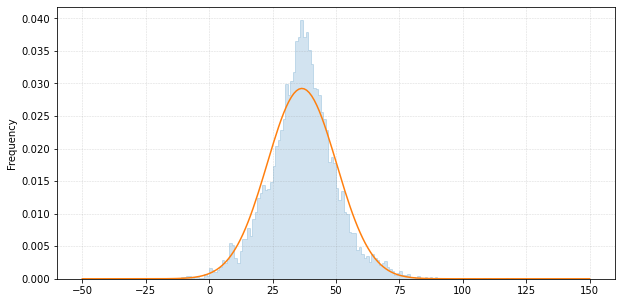

In [41]:
import scipy.stats
# let's plot a histogram of price distribution CH in 20219 (normalized -> density = True)

x_min = -50
x_max = 150
a_step = 1

#choose Serie to do statistics
ts_stat = ts_pricesCH[the_up2date_index_h]

plt.figure(figsize=(10,5))
ts_stat.plot(kind="hist",fill=True,alpha=0.2,histtype='step', bins = range(x_min,x_max, a_step), density = True)
# let's compare to a gaussian distribution with same mean and standard deviation
x = np.linspace(x_min,x_max, round((x_max - x_min)/a_step) )
plt.plot(x,scipy.stats.norm.pdf(x,ts_stat.mean(),ts_stat.std()))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

print('Mean of prices : %3.2f [Euro/MWh] with Std. Dev. : %1.2f' % (ts_stat.mean(), ts_stat.std() ) )

In [42]:
dfs = ts_stat
print(stats.describe(dfs)) # Print some descriptive statistics
dfs.describe() # the pandas describe prints similar statistics

DescribeResult(nobs=15672, minmax=(-59.61, 119.69), mean=36.561987621235325, variance=186.10783004183514, skewness=-0.06595282418110408, kurtosis=2.3137611853439166)


count    15672.000000
mean        36.561988
std         13.642134
min        -59.610000
25%         28.930000
50%         36.720000
75%         44.300000
max        119.690000
Name: Day Ahead Prices CH, dtype: float64

In [43]:
# D Agostino-Pearson test
k2, p = stats.normaltest(dfs) 
print("D'Agostino-Pearson -> p-value = %1.7e" % p)

# shapiro test
s,p = stats.shapiro(dfs)
print('Shapiro -> Test statistic = ',s,' p-value =',p)

D'Agostino-Pearson -> p-value = 2.5992109e-188
Shapiro -> Test statistic =  0.981019914150238  p-value = 5.648073590307608e-41


/Users/Philipp/anaconda3/envs/CAS_ADS_2020/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### <u>Conclusion:</u> there is no gaussian distribution, one sees an asymmetry (at lower price). There is not that much to conclude about this overall distribution investigation. Further down is the Overview in respect of seasonality and product.

Mean of prices (peak, summer): 36.77 [Euro/MWh] with Std. Dev. : 12.42
Mean of prices (off-peak, summer): 30.35 [Euro/MWh] with Std. Dev. : 11.91
Mean of prices (peak, winter): 47.63 [Euro/MWh] with Std. Dev. : 12.63
Mean of prices (off-peak, winter): 38.18 [Euro/MWh] with Std. Dev. : 12.64


<Figure size 432x288 with 0 Axes>

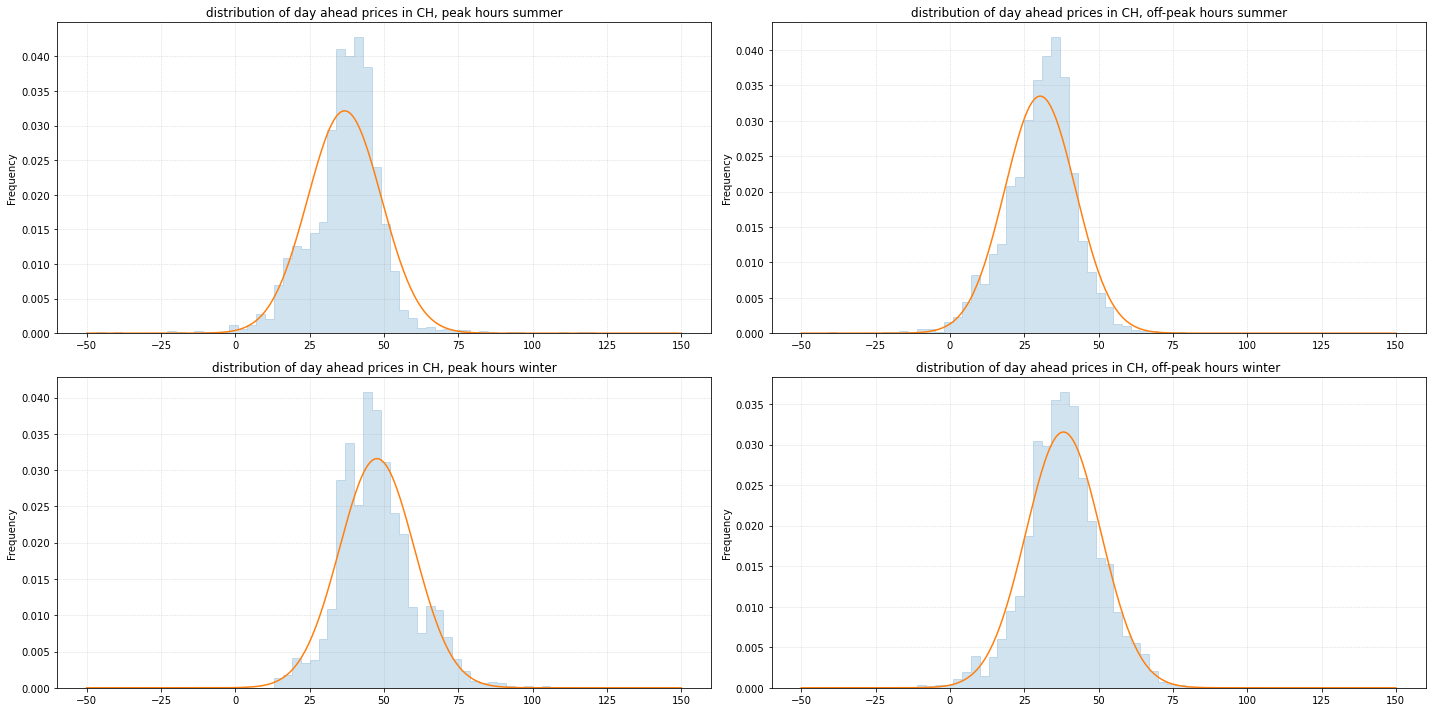

In [44]:
#look at the distribution of prices in a seasonal and product view
x_min = -50
x_max = 150
a_step = 3

plt.figure()
fig, axes = plt.subplots(2,2, figsize=(20,10),  tight_layout=True)
a_font_size = 10

plt.subplot(2,2,1)
ts_pricesCH[an_index_Q2Q3_PH].plot(kind="hist",fill=True,alpha=0.2,histtype='step', bins = range(x_min,x_max, a_step), density = True)
# let's compare to a gaussian distribution with same mean and standard deviation
x = np.linspace(x_min,x_max, round((x_max - x_min)/(a_step/5) ))
plt.plot(x,scipy.stats.norm.pdf(x,ts_pricesCH[an_index_Q2Q3_PH].mean(),ts_pricesCH[an_index_Q2Q3_PH].std()))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('distribution of day ahead prices in CH, peak hours summer')

print('Mean of prices (peak, summer): %3.2f [Euro/MWh] with Std. Dev. : %1.2f' % (ts_pricesCH[an_index_Q2Q3_PH].mean(), ts_pricesCH[an_index_Q2Q3_PH].std() ) )

plt.subplot(2,2,2)
ts_pricesCH[an_index_Q2Q3_OPH].plot(kind="hist",fill=True,alpha=0.2,histtype='step', bins = range(x_min,x_max, a_step), density = True)
# let's compare to a gaussian distribution with same mean and standard deviation
x = np.linspace(x_min,x_max, round((x_max - x_min)/(a_step/5) ))
plt.plot(x,scipy.stats.norm.pdf(x,ts_pricesCH[an_index_Q2Q3_OPH].mean(),ts_pricesCH[an_index_Q2Q3_OPH].std()))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('distribution of day ahead prices in CH, off-peak hours summer')

print('Mean of prices (off-peak, summer): %3.2f [Euro/MWh] with Std. Dev. : %1.2f' % (ts_pricesCH[an_index_Q2Q3_OPH].mean(), ts_pricesCH[an_index_Q2Q3_OPH].std() ) )

plt.subplot(2,2,3)
ts_pricesCH[an_index_Q1Q4_PH].plot(kind="hist",fill=True,alpha=0.2,histtype='step', bins = range(x_min,x_max, a_step), density = True)
# let's compare to a gaussian distribution with same mean and standard deviation
x = np.linspace(x_min,x_max, round((x_max - x_min)/(a_step/5) ))
plt.plot(x,scipy.stats.norm.pdf(x,ts_pricesCH[an_index_Q1Q4_PH].mean(),ts_pricesCH[an_index_Q1Q4_PH].std()))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('distribution of day ahead prices in CH, peak hours winter')

print('Mean of prices (peak, winter): %3.2f [Euro/MWh] with Std. Dev. : %1.2f' % (ts_pricesCH[an_index_Q1Q4_PH].mean(), ts_pricesCH[an_index_Q1Q4_PH].std() ) )

plt.subplot(2,2,4)
ts_pricesCH[an_index_Q1Q4_OPH].plot(kind="hist",fill=True,alpha=0.2,histtype='step', bins = range(x_min,x_max, a_step), density = True)
# let's compare to a gaussian distribution with same mean and standard deviation
x = np.linspace(x_min,x_max, round((x_max - x_min)/(a_step/5) ))
plt.plot(x,scipy.stats.norm.pdf(x,ts_pricesCH[an_index_Q1Q4_OPH].mean(),ts_pricesCH[an_index_Q1Q4_OPH].std()))
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.title('distribution of day ahead prices in CH, off-peak hours winter')

print('Mean of prices (off-peak, winter): %3.2f [Euro/MWh] with Std. Dev. : %1.2f' % (ts_pricesCH[an_index_Q1Q4_OPH].mean(), ts_pricesCH[an_index_Q1Q4_OPH].std() ) )

#### <u>conclusion:</u> 
- the distributions in respect of seasonality and product show clear signs of *disturbances*. It seems as if there are different regimes where price settlement is taking place. 
- time based examination for what data intervall to learn with when forecasting is crucial (reason for this could be that market strategies and drivers change over time).


#### For further investigation we making box plots of all hours (24h) - hourly price distribution (seasonal-/product-wise) 

/Users/Philipp/anaconda3/envs/CAS_ADS_2020/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/Philipp/anaconda3/envs/CAS_ADS_2020/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/Philipp/anaconda3/envs/CAS_ADS_2020/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

Text(0.5, 1.0, 'hourly distribution off-peak, winter')

<Figure size 432x288 with 0 Axes>

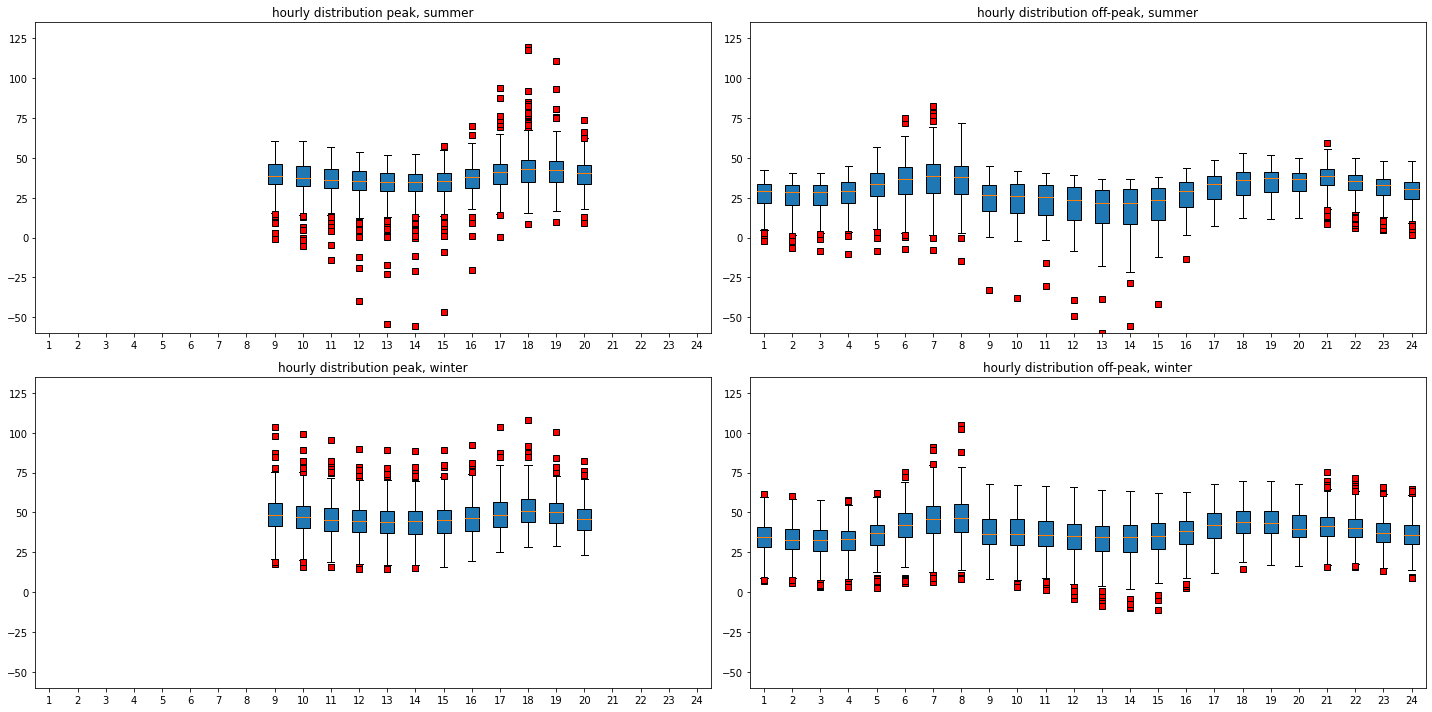

In [45]:
## create an hour index -> means all hours of a year of the same day hour, i.e. hour 9 of each day
#an_hour_index = pd.date_range('2019-01-01 09:00:00', freq = 'D', periods = 365, closed = 'left')
#an_hour_index
##create an hour index for peak hour in winter
#an_hour_index_Q1Q4_PH = an_index_Q1Q4_PH[an_index_Q1Q4_PH.isin(an_hour_index)]
#an_hour_index_Q1Q4_PH

plt.figure()
fig, axes = plt.subplots(2,2, figsize=(20,10),  tight_layout=True)
a_font_size = 10
red_square = dict(markerfacecolor='r', marker='s')

# -------------------

a_seq = []
a_index = an_index_Q2Q3_PH.copy()
for i in range(0,24):
    a_str = '2019-01-01 %02i' %i + ':00:00'
    an_hourly_index = pd.date_range(a_str, freq = 'D', periods = 730, closed = 'left')  #<- this line not save for scaling
    a_selecting_hour_index = a_index[a_index.isin(an_hourly_index)]
    a_prices = ts_pricesCH[a_selecting_hour_index]
    a_seq.append(a_prices)
    
#an_hour_index
#a_prices
plt.subplot(2,2,1)
plt.boxplot(a_seq, patch_artist = True, manage_ticks = True, meanline = True, flierprops=red_square)
plt.ylim([-60, 135])
plt.title('hourly distribution peak, summer')
#plt.show()

# -------------------

a_seq = []
a_index = an_index_Q2Q3_OPH.copy()
for i in range(0,24):
    a_str = '2019-01-01 %02i' %i + ':00:00'
    an_hourly_index = pd.date_range(a_str, freq = 'D', periods = 730, closed = 'left')  #<- this line not save for scaling
    a_selecting_hour_index = a_index[a_index.isin(an_hourly_index)]
    a_prices = ts_pricesCH[a_selecting_hour_index]
    a_seq.append(a_prices)
    
#an_hour_index
#a_prices
plt.subplot(2,2,2)
plt.boxplot(a_seq, patch_artist = True, manage_ticks = True, meanline = True, flierprops=red_square)
plt.ylim([-60, 135])
plt.title('hourly distribution off-peak, summer')
#plt.show()

# ----------------------

a_seq = []
a_index = an_index_Q1Q4_PH.copy()
for i in range(0,24):
    a_str = '2019-01-01 %02i' %i + ':00:00'
    an_hourly_index = pd.date_range(a_str, freq = 'D', periods = 730, closed = 'left')  #<- this line not save for scaling
    a_selecting_hour_index = a_index[a_index.isin(an_hourly_index)]
    a_prices = ts_pricesCH[a_selecting_hour_index]
    a_seq.append(a_prices)

#an_hour_index
#a_prices
plt.subplot(2,2,3)
plt.boxplot(a_seq, patch_artist = True, manage_ticks = True, meanline = True, flierprops=red_square)
plt.ylim([-60, 135])
plt.title('hourly distribution peak, winter')
#plt.show()

# -------------------

a_seq = []
a_index = an_index_Q1Q4_OPH.copy()
for i in range(0,24):
    a_str = '2019-01-01 %02i' %i + ':00:00'
    an_hourly_index = pd.date_range(a_str, freq = 'D', periods = 730, closed = 'left')  #<- this line not save for scaling
    a_selecting_hour_index = a_index[a_index.isin(an_hourly_index)]
    a_prices = ts_pricesCH[a_selecting_hour_index]
    a_seq.append(a_prices)
    
#an_hour_index
#a_prices
plt.subplot(2,2,4)
plt.boxplot(a_seq, patch_artist = True, manage_ticks = True, meanline = True, flierprops=red_square)
plt.ylim([-60, 135])
plt.title('hourly distribution off-peak, winter')
#plt.show()


#### <u>conclusion:</u><br>
- many outlayers confirm the value for kurtosis, kind and number of outlayers differe over seasons
- peak and offpeak show different kind of distribution
- winter - summer differentiation seems important for peak hours (say working hours) and less important for off-peak hours
- variances of hourly prices seem to be higher in off-peak than peak time
- summer has more probability for lower price values (in term of outlayers) than winter, winter shows same to high prices. 

**This means that a differantiation in fitted regimes of seasonality and product (best would be hourly but there would be too less statistics) makes sense.**

### 2.2. Correlations  <br>
In this section we do intensiv evaluation of correlation of time series.
Hypothesis of correlations are: <br>
1) renewables Generation "wind + solar" vs. market prices <br>
2) load vs. prices <br>
3) Overall Generation vs. prices <br>
4) swiss import (according to transmission capacity) vs. prices <br>



In [46]:
#create a datetimeindex where you can test the correlation for a certain time intervall
a_start = '2019-01-01'
a_end = '2020-10-15'
a_selection_in_time=pd.date_range(a_start, a_end , freq = 'h', closed = 'left')   #pd.date_range('2019-01-01 09:00:00', freq = 'D', periods = 365, closed = 'left')
#a_selection_in_time
#set a flag to draw in correlation plots
a_selection_flag = True
a_reggression_flag = True

#just adapt the following indexes to the intervall
an_index_Q1Q4_PH_s = an_index_Q1Q4_PH[ an_index_Q1Q4_PH.isin(a_selection_in_time) ]
an_index_Q1Q4_OPH_s = an_index_Q1Q4_OPH[ an_index_Q1Q4_OPH.isin(a_selection_in_time) ]
an_index_Q2Q3_PH_s = an_index_Q2Q3_PH[ an_index_Q2Q3_PH.isin(a_selection_in_time) ]
an_index_Q2Q3_OPH_s = an_index_Q2Q3_OPH[ an_index_Q2Q3_OPH.isin(a_selection_in_time) ]

#### 2.2.1. Examine Correlation between country prices CH <-> D
First we look at the correlation between prices in CH and D. <br>
So this will justify why we include data of other bidding zones.

Q2Q3: 
slope : 1.11E+00 +/- 8.41E-03,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.87
slope : 1.17E+00 +/- 1.28E-02,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.85
Q1Q4: 
slope : 9.64E-01 +/- 1.43E-02,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.71
slope : 9.29E-01 +/- 1.23E-02,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.83


<Figure size 432x288 with 0 Axes>

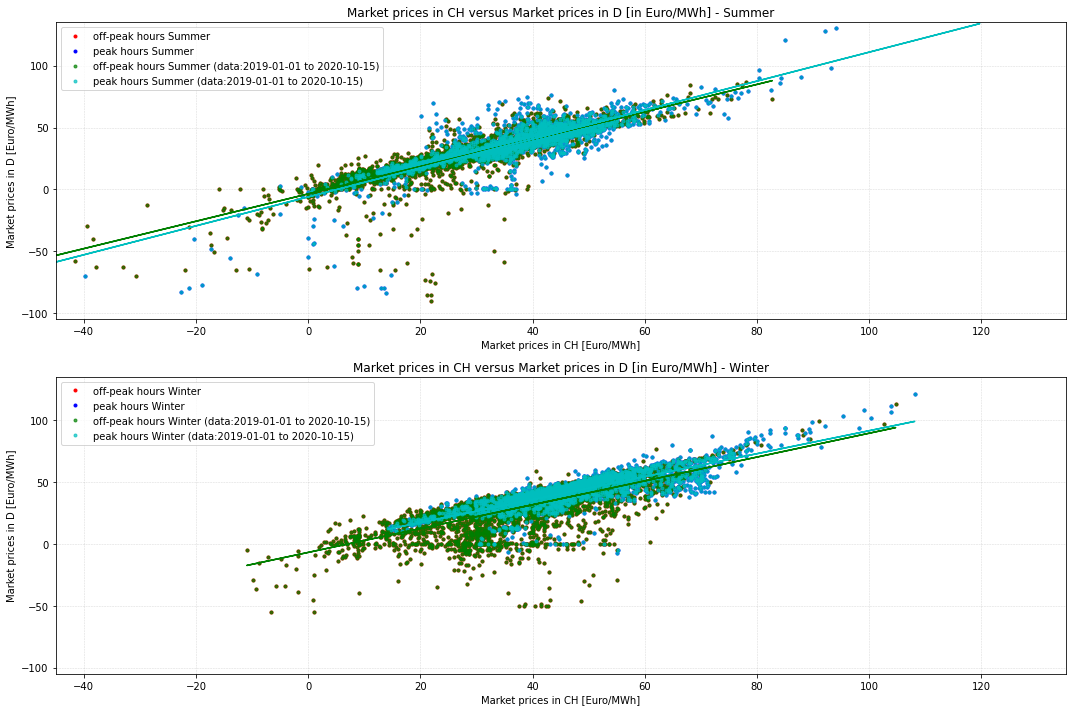

In [47]:
# look at correlation between German and CH prices

#drawing time Series
ts_x = ts_pricesCH
ts_y = ts_pricesD

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Market prices in CH versus Market prices in D [in Euro/MWh] - Summer')
plt.xlabel('Market prices in CH [Euro/MWh]')
plt.ylabel('Market prices in D [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(-45, 135)
plt.ylim(-105, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Market prices in CH versus Market prices in D [in Euro/MWh] - Winter')
plt.xlabel('Market prices in CH [Euro/MWh]')
plt.ylabel('Market prices in D [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(-45, 135)
plt.ylim(-105, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> strong correlation, summer and winter (significantly) different slopes.

#### 2.2.2. Examining Renewable Correlation

Q2Q3: 
slope : -4.11E-02 +/- 2.46E-03,  p-value for Hypt. "no slope": 6.19E-61 -> r-value: -0.22
slope : -3.37E-02 +/- 2.52E-03,  p-value for Hypt. "no slope": 1.37E-39 -> r-value: -0.23
Q1Q4: 
slope : -6.55E-02 +/- 5.27E-03,  p-value for Hypt. "no slope": 6.55E-35 -> r-value: -0.18
slope : -7.38E-02 +/- 4.55E-03,  p-value for Hypt. "no slope": 2.59E-56 -> r-value: -0.31


<Figure size 432x288 with 0 Axes>

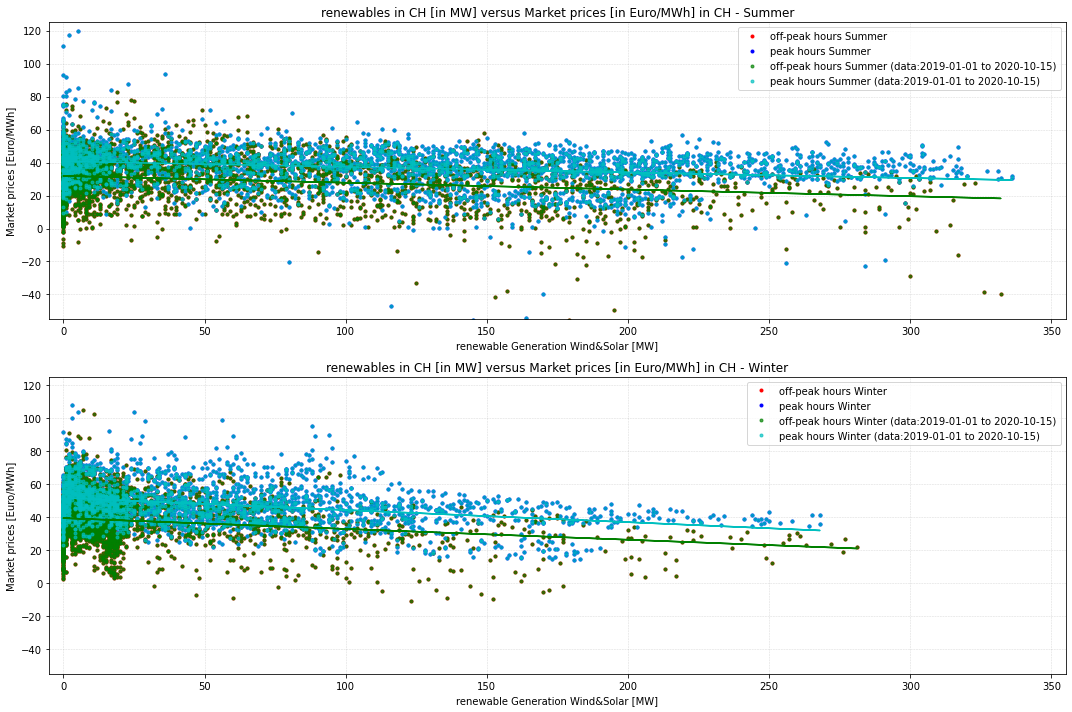

In [48]:
ts_RenGenAllCH = ts_RenGenSolarCH[an_index4Presentation] + ts_RenGenWindCH[an_index4Presentation]
#ts_RenGenAllCH

#drawing time Series
ts_x = ts_RenGenAllCH
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

# plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
#off-peak summer (red light) and winter (red dark)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH],  '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )

# -------
plt.title('renewables in CH [in MW] versus Market prices [in Euro/MWh] in CH - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(-5, 355)
plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH],  '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
# -------
plt.title('renewables in CH [in MW] versus Market prices [in Euro/MWh] in CH - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(-5, 355)
plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)


#### <u>Conclusion:</u> Renewables CH do not really have a big influence on prices (max. in winter/peak)! low correlation, low slope with big error!

Q2Q3: 
slope : -5.16E-04 +/- 1.53E-05,  p-value for Hypt. "no slope": 4.64E-228 -> r-value: -0.41
slope : -5.22E-04 +/- 1.73E-05,  p-value for Hypt. "no slope": 1.05E-175 -> r-value: -0.48
Q1Q4: 
slope : -3.07E-04 +/- 1.58E-05,  p-value for Hypt. "no slope": 2.11E-80 -> r-value: -0.28
slope : -4.16E-04 +/- 1.97E-05,  p-value for Hypt. "no slope": 4.43E-91 -> r-value: -0.39


<Figure size 432x288 with 0 Axes>

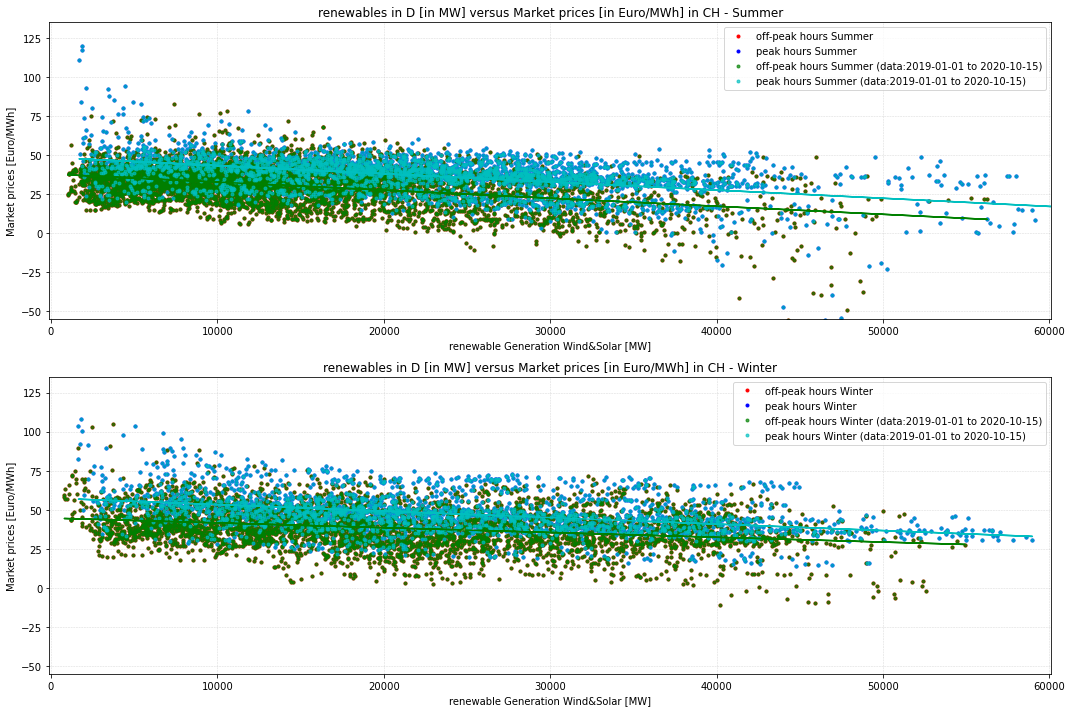

In [49]:
#look RenGenAll
ts_RenGenAllD = ts_RenGenOffWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenOnWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenSolarD.resample('H').mean()[an_index4Presentation]


#drawing time Series
ts_x = ts_RenGenAllD
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


#plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllD[an_index4Presentation], ts_pricesCH[an_index4Presentation], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )

#-----------
plt.title('renewables in D [in MW] versus Market prices [in Euro/MWh] in CH - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(-100, 60100)
plt.ylim(-55, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllD[an_index4Presentation], ts_pricesCH[an_index4Presentation], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('renewables in D [in MW] versus Market prices [in Euro/MWh] in CH - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(-100, 60100)
plt.ylim(-55, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> renewables in Germany are impacting CH Prices! Correlation quite ok, summer higher than in Winter (least in Peak/Winter), slope&precision are ok. Nevertheless, at high values and low values there is non-linear correlation (means lin-Reg-Model will be limited precision).

Q2Q3: 
slope : -8.48E-04 +/- 1.81E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: -0.53
slope : -1.02E-03 +/- 2.00E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: -0.67
Q1Q4: 
slope : -1.01E-03 +/- 1.64E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: -0.68
slope : -8.13E-04 +/- 1.73E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: -0.69


<Figure size 432x288 with 0 Axes>

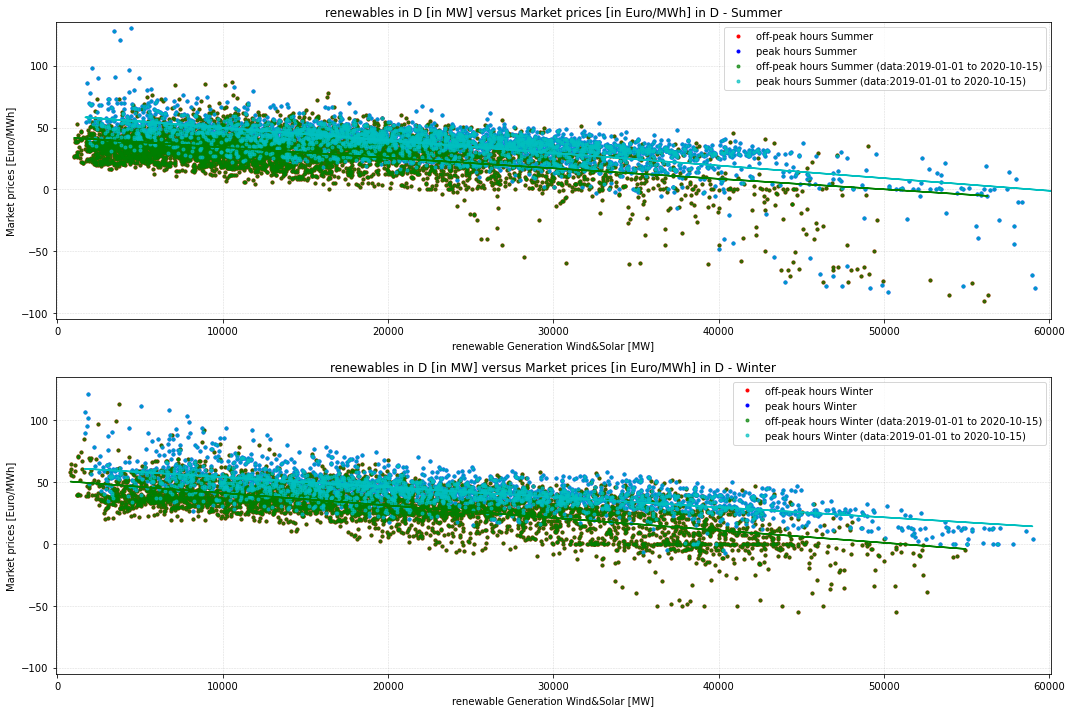

In [50]:
ts_RenGenAllD = ts_RenGenOffWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenOnWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenSolarD.resample('H').mean()[an_index4Presentation]

#drawing time Series
ts_x = ts_RenGenAllD
ts_y = ts_pricesD

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

#plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllD[an_index4Presentation], ts_pricesD[an_index4Presentation], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('renewables in D [in MW] versus Market prices [in Euro/MWh] in D - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(-100, 60100)
plt.ylim(-105, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllD[an_index4Presentation], ts_pricesD[an_index4Presentation], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('renewables in D [in MW] versus Market prices [in Euro/MWh] in D - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(-100, 60100)
plt.ylim(-105, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> strong influence on prices in Germany (reneable D on prices in D)! high r-value, clear slopes with low errors. Nevertheless, lots of outlayers and not linear in lowest and highest prices, so limitation for a linear Modelling.

Q2Q3: 
slope : -1.46E-03 +/- 6.06E-05,  p-value for Hypt. "no slope": 5.38E-122 -> r-value: -0.31
slope : -1.57E-03 +/- 7.84E-05,  p-value for Hypt. "no slope": 3.28E-84 -> r-value: -0.34
Q1Q4: 
slope : -1.33E-03 +/- 5.24E-05,  p-value for Hypt. "no slope": 6.61E-132 -> r-value: -0.36
slope : -1.63E-03 +/- 6.50E-05,  p-value for Hypt. "no slope": 4.30E-123 -> r-value: -0.45


<Figure size 432x288 with 0 Axes>

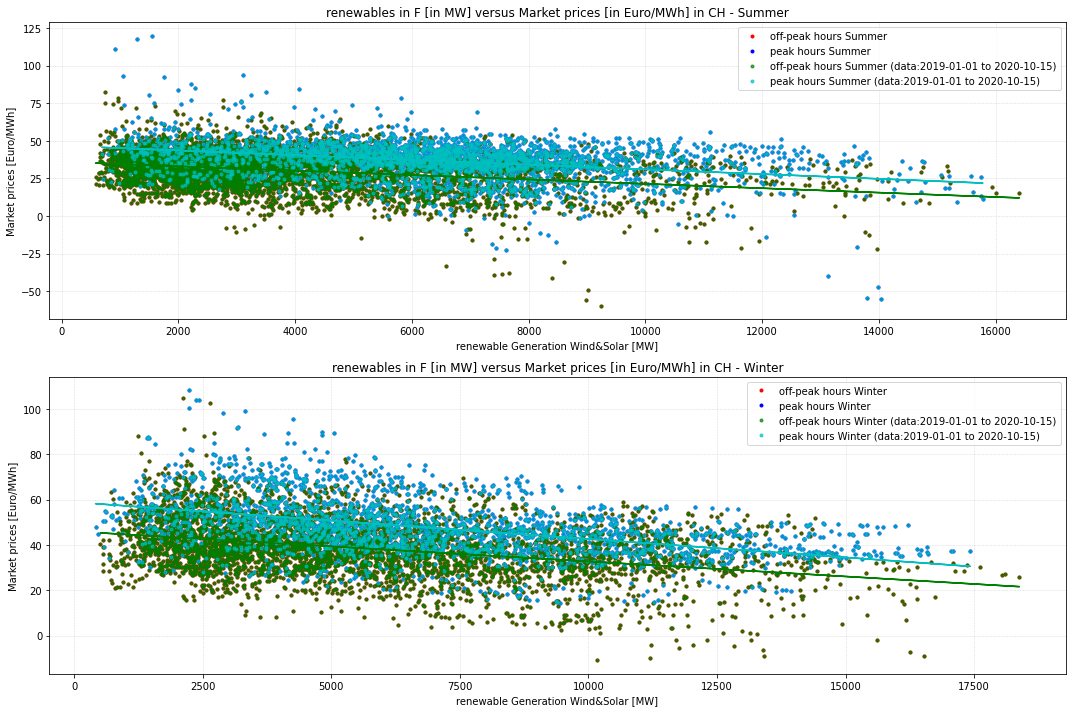

In [51]:
ts_RenGenAllF = ts_RenGenSolarF[an_index4Presentation] + ts_RenGenWindF[an_index4Presentation]
#ts_RenGenAllF

#drawing time Series
ts_x = ts_RenGenAllF
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

# plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
#off-peak summer (red light) and winter (red dark)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH],  '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )

# -------
plt.title('renewables in F [in MW] versus Market prices [in Euro/MWh] in CH - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(-5, 355)
#plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH],  '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
# -------
plt.title('renewables in F [in MW] versus Market prices [in Euro/MWh] in CH - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(-5, 355)
#plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> also slight correlation (similar to them in Germany) - slope (astonishingly) steeper.

Q2Q3: 
slope : -2.93E-03 +/- 1.51E-04,  p-value for Hypt. "no slope": 5.78E-81 -> r-value: -0.26
slope : -2.88E-03 +/- 1.56E-04,  p-value for Hypt. "no slope": 1.48E-72 -> r-value: -0.32
Q1Q4: 
slope : -3.44E-03 +/- 2.85E-04,  p-value for Hypt. "no slope": 4.58E-33 -> r-value: -0.18
slope : -3.35E-03 +/- 2.22E-04,  p-value for Hypt. "no slope": 3.67E-49 -> r-value: -0.30


<Figure size 432x288 with 0 Axes>

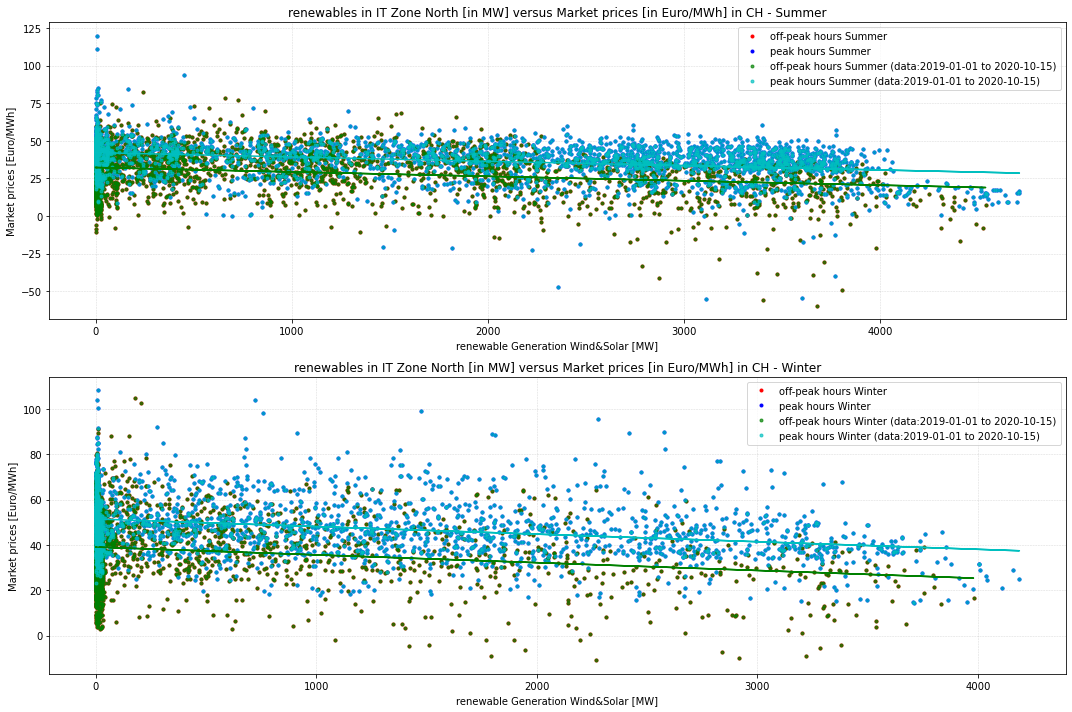

In [52]:
ts_RenGenAllIT = ts_RenGenSolarIT[an_index4Presentation] + ts_RenGenWindIT[an_index4Presentation]
#ts_RenGenAllCH

#drawing time Series
ts_x = ts_RenGenAllIT
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

# plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
#off-peak summer (red light) and winter (red dark)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH],  '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )

# -------
plt.title('renewables in IT Zone North [in MW] versus Market prices [in Euro/MWh] in CH - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(-5, 355)
#plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllCH[an_index4Presentation], ts_pricesCH[an_index4Presentation],  '.y', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH],  '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH],  '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
# -------
plt.title('renewables in IT Zone North [in MW] versus Market prices [in Euro/MWh] in CH - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(-5, 355)
#plt.ylim(-55, 125)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> hypothetical influence, more in peak time than off-peak ("assuming indirect effect" -> less selling to Italy). Although we did not consider whole renewable generation in Italy but only the on in northern zone.

#### 2.2.3. Examine Load Correlations

Q2Q3: 
slope : 5.21E-03 +/- 2.40E-04,  p-value for Hypt. "no slope": 4.08E-100 -> r-value: 0.28
slope : 1.51E-03 +/- 3.99E-04,  p-value for Hypt. "no slope": 1.52E-04 -> r-value: 0.07
Q1Q4: 
slope : 9.68E-03 +/- 2.03E-04,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.58
slope : 8.21E-03 +/- 2.81E-04,  p-value for Hypt. "no slope": 2.79E-161 -> r-value: 0.51


<Figure size 432x288 with 0 Axes>

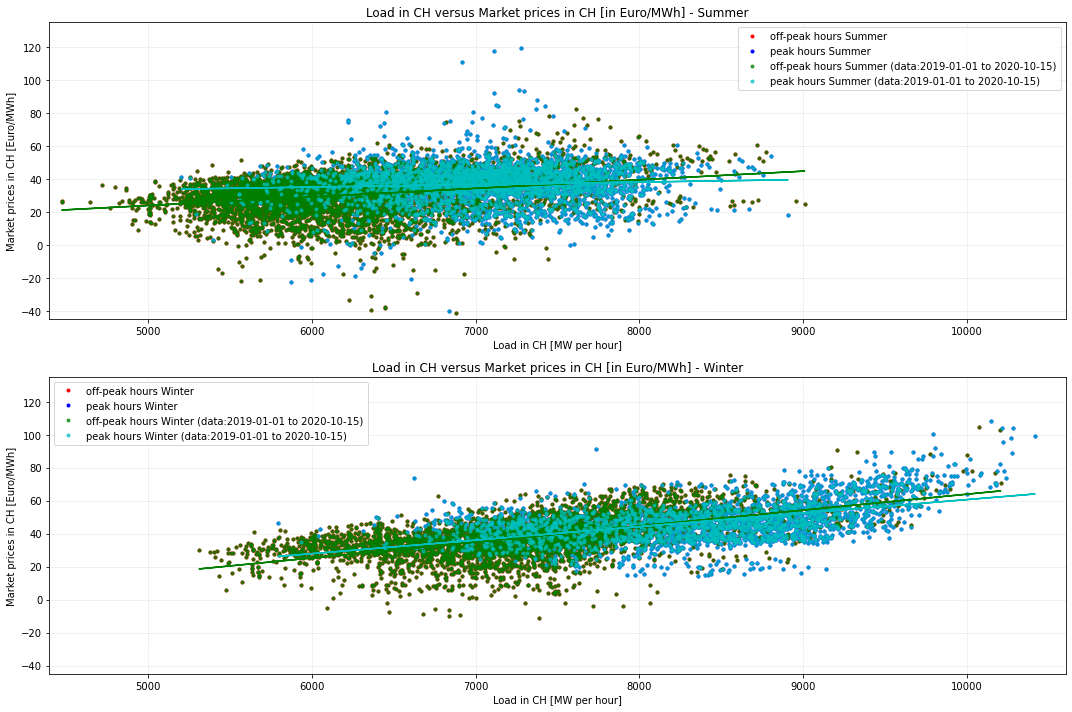

In [53]:
# look at correlation between Load and prices in CH

#drawing time Series
ts_x = ts_LoadCH
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in CH versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Load in CH [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in CH versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Load in CH [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>Conclusion:</u> Wintertime strongly correlates, summer almost not, i.e. summer peak is very opportunistic. In summer peak there is too much Generation cause of water inflow, selling to other countries dominates the trading regime. 

Q2Q3: 
slope : 7.35E-04 +/- 2.04E-05,  p-value for Hypt. "no slope": 4.15E-255 -> r-value: 0.43
slope : 6.29E-04 +/- 5.00E-05,  p-value for Hypt. "no slope": 2.11E-35 -> r-value: 0.22
Q1Q4: 
slope : 9.67E-04 +/- 2.23E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.55
slope : 7.20E-04 +/- 5.42E-05,  p-value for Hypt. "no slope": 6.46E-39 -> r-value: 0.26


<Figure size 432x288 with 0 Axes>

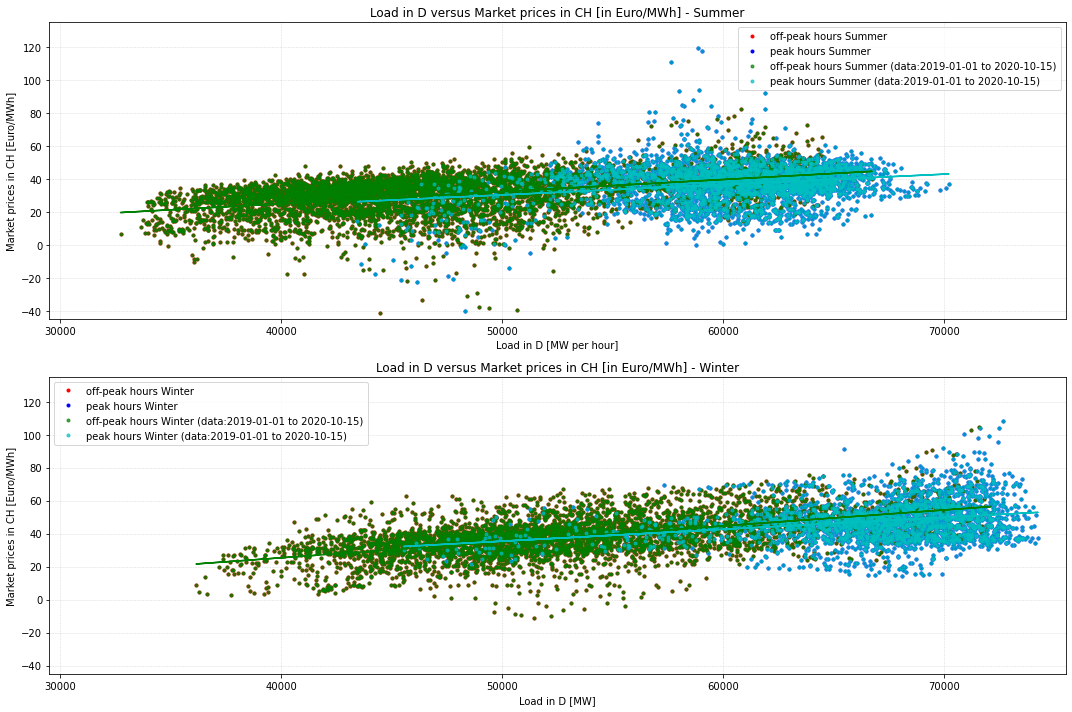

In [54]:
#does Germany Load affect swiss market prices ..

#drawing time Series
ts_x = ts_LoadD.resample('H').mean()[an_index4Presentation]
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x.resample('H').mean()[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x.resample('H').mean()[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in D versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Load in D [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(29500, 75500)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x.resample('H').mean()[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x.resample('H').mean()[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in D versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Load in D [MW]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(29500, 75500)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion:</u> higher correlation in off-peak time when import to CH.

Q2Q3: 
slope : 1.04E-03 +/- 2.36E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.51
slope : 1.17E-03 +/- 4.25E-05,  p-value for Hypt. "no slope": 1.64E-148 -> r-value: 0.44
Q1Q4: 
slope : 9.62E-04 +/- 1.46E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.70
slope : 8.68E-04 +/- 2.14E-05,  p-value for Hypt. "no slope": 1.07E-276 -> r-value: 0.63


<Figure size 432x288 with 0 Axes>

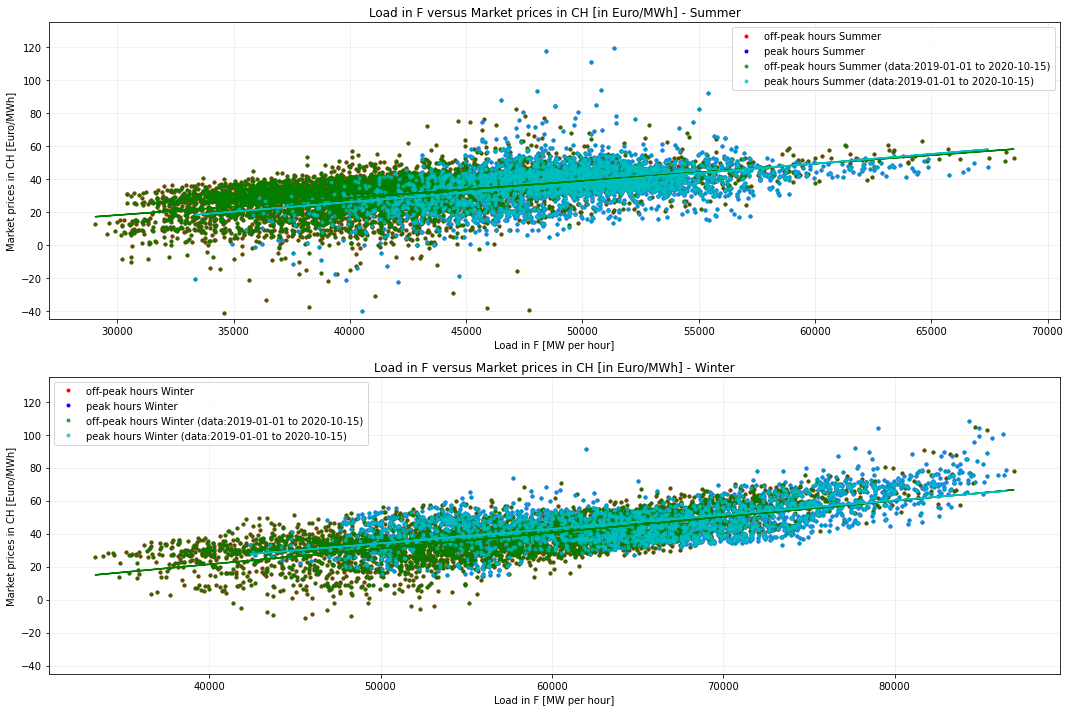

In [55]:
# look at correlation between Load F and prices in CH

#drawing time Series
ts_x = ts_LoadF
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in F versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Load in F [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in F versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Load in F [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion:</u> good correlation also with F, stronger in winter time - also opportunistic selling to France from CH (leads to price coupling).

Q2Q3: 
slope : 2.02E-03 +/- 3.24E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.64
slope : 1.65E-03 +/- 4.93E-05,  p-value for Hypt. "no slope": 5.84E-211 -> r-value: 0.51
Q1Q4: 
slope : 2.16E-03 +/- 3.93E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.64
slope : 2.01E-03 +/- 6.19E-05,  p-value for Hypt. "no slope": 2.95E-192 -> r-value: 0.55


<Figure size 432x288 with 0 Axes>

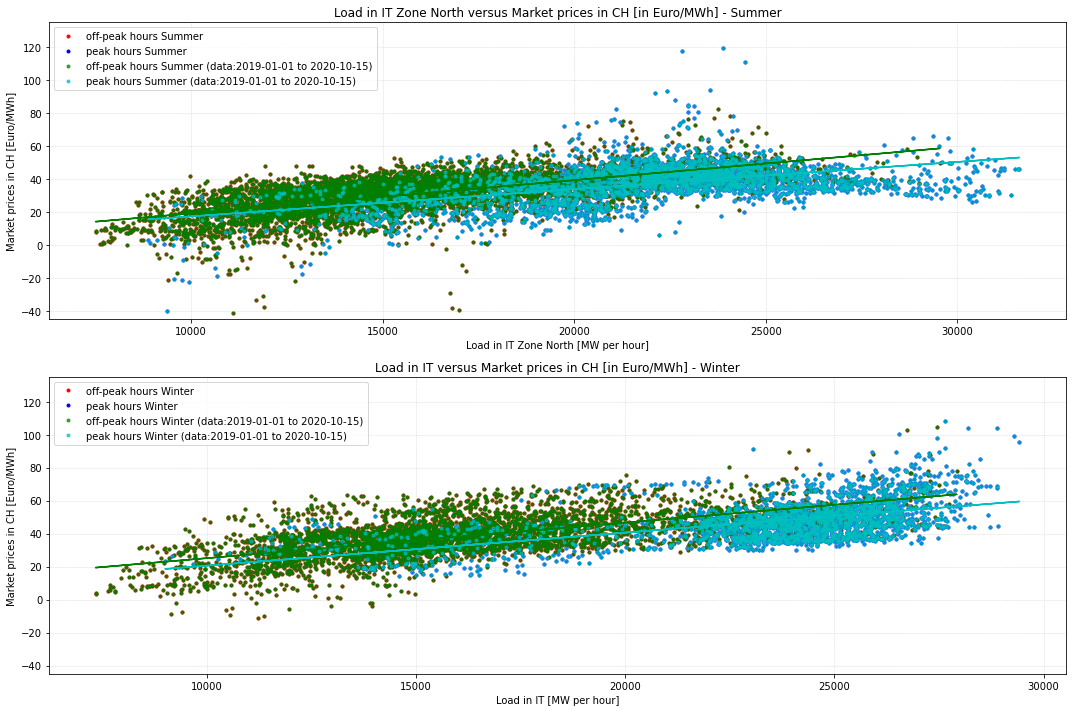

In [56]:
# look at correlation between Load IT and prices in CH

#drawing time Series
ts_x = ts_LoadIT
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in IT Zone North versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Load in IT Zone North [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Load in IT versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Load in IT [MW per hour]')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(4400, 10600)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion:</u> evident correlation cause of selling to IT as a transit country (rather in the offpeak than peak), this sets prices in CH. 

#### Additional Correlation by fraction Generation vs. Load?
One could think of reducing dimensionality if one would use a combined feature instead of train and fit both features.
So these correlation could be studied - in the end not used further at the moment (cause no limit in calculation capacity).

Q2Q3: 
slope : 2.68E+01 +/- 5.68E-01,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.53
slope : 2.41E+01 +/- 6.84E-01,  p-value for Hypt. "no slope": 5.32E-229 -> r-value: 0.53
Q1Q4: 
slope : 2.60E+01 +/- 1.24E+00,  p-value for Hypt. "no slope": 6.45E-94 -> r-value: 0.30
slope : 2.98E+01 +/- 1.16E+00,  p-value for Hypt. "no slope": 7.57E-130 -> r-value: 0.46


<Figure size 432x288 with 0 Axes>

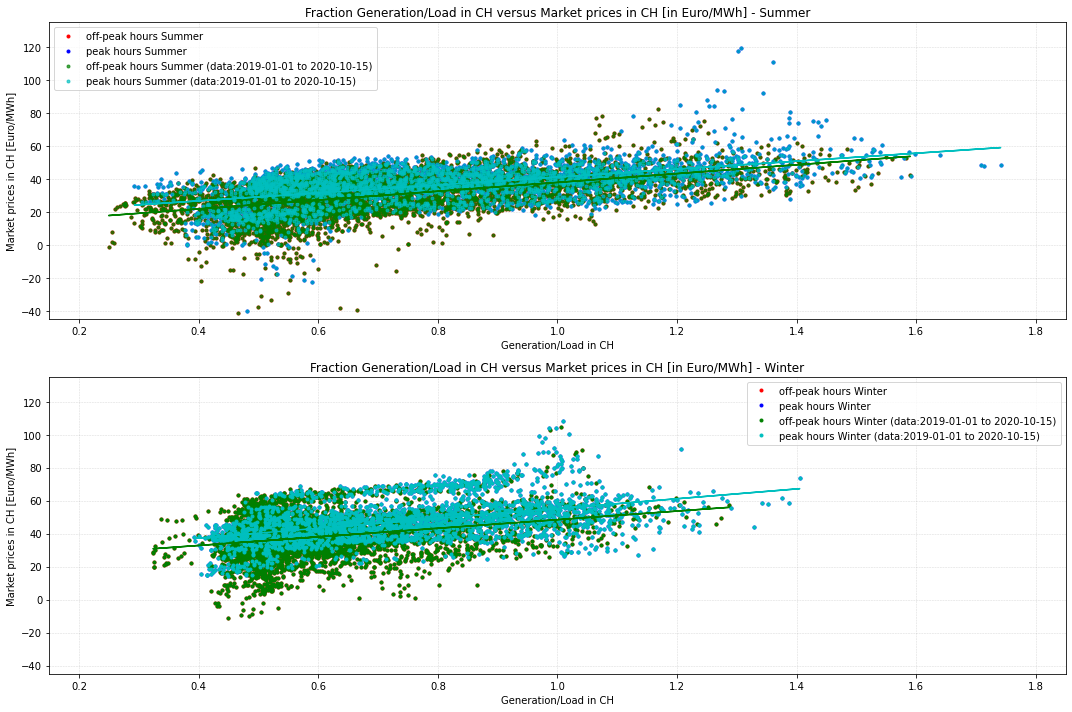

In [57]:
#probabely one gets a better correlation when Generation/Load versus Prices 
a_fraction = ts_GenCH[an_index4Presentation]/ts_LoadCH[an_index4Presentation]

#drawing time Series
ts_x = a_fraction
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation/Load in CH versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Generation/Load in CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(0.15, 1.85)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g')
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c')
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation/Load in CH versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Generation/Load in CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(0.15, 1.85)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

Q2Q3: 
slope : -2.06E+01 +/- 9.06E-01,  p-value for Hypt. "no slope": 1.59E-109 -> r-value: -0.29
slope : -2.67E+01 +/- 1.30E+00,  p-value for Hypt. "no slope": 1.60E-88 -> r-value: -0.34
Q1Q4: 
slope : -1.04E+01 +/- 1.29E+00,  p-value for Hypt. "no slope": 6.33E-16 -> r-value: -0.12
slope : -7.02E-01 +/- 2.21E+00,  p-value for Hypt. "no slope": 7.51E-01 -> r-value: -0.01


<Figure size 432x288 with 0 Axes>

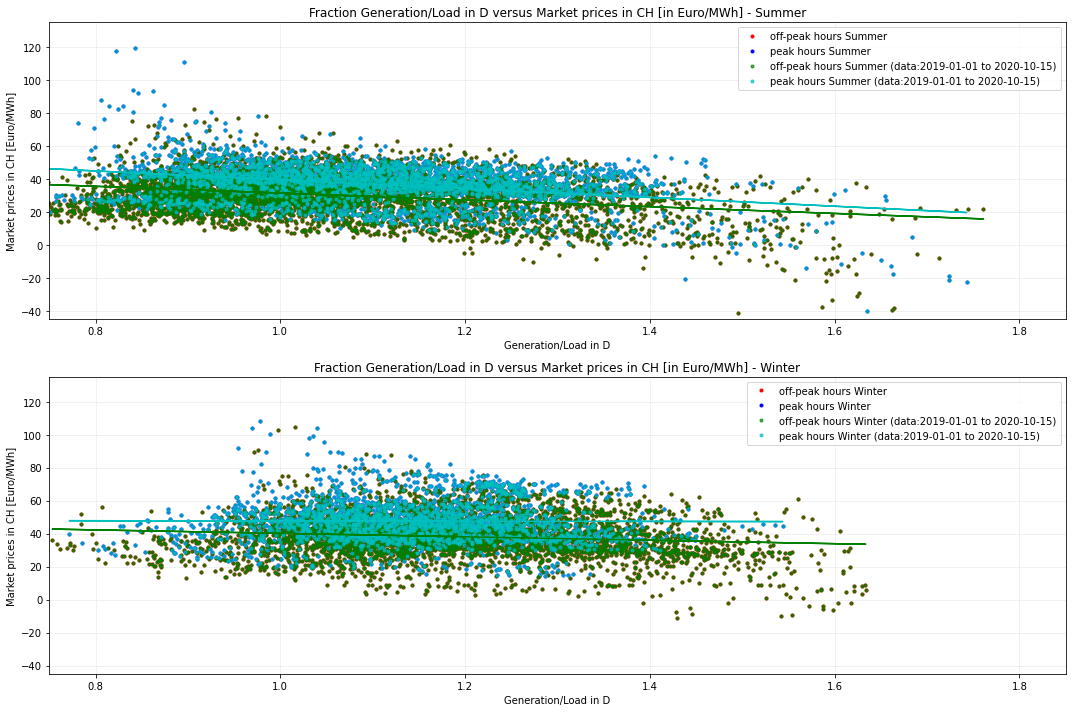

In [58]:
#probabely one gets a better correlation when Generation/Load versus Prices 
a_fraction = ts_GenD[an_index4Presentation]/ts_LoadD.resample('H').mean()[an_index4Presentation]

#drawing time Series
ts_x = a_fraction
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation/Load in D versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Generation/Load in D')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(0.75, 1.85)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation/Load in D versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Generation/Load in D')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(0.75, 1.85)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

Q2Q3: 
slope : -4.75E+01 +/- 9.90E-01,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: -0.54
slope : -5.61E+01 +/- 1.45E+00,  p-value for Hypt. "no slope": 5.20E-268 -> r-value: -0.57
Q1Q4: 
slope : -3.73E+01 +/- 1.15E+00,  p-value for Hypt. "no slope": 2.71E-206 -> r-value: -0.44
slope : -4.89E+01 +/- 1.76E+00,  p-value for Hypt. "no slope": 5.46E-148 -> r-value: -0.49


<Figure size 432x288 with 0 Axes>

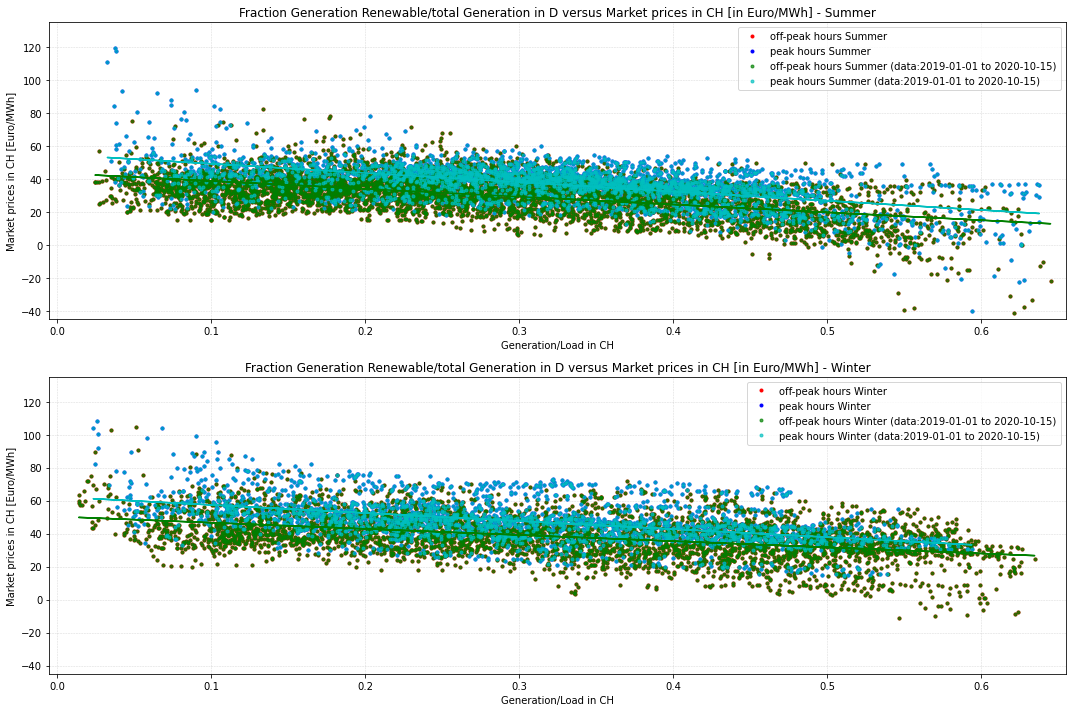

In [59]:
#Last but not least, probabely one gets a better correlation when Generation Renwable/Total Generation in D versus Prices 
ts_RenGenAllD = ts_RenGenOffWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenOnWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenSolarD.resample('H').mean()[an_index4Presentation]
a_fraction = ts_RenGenAllD[an_index4Presentation]/ts_GenD[an_index4Presentation]

#drawing time Series
ts_x = a_fraction
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation Renewable/total Generation in D versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Generation/Load in CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.xlim(-0.005, 0.655)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Fraction Generation Renewable/total Generation in D versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Generation/Load in CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.xlim(-0.005, 0.655)
plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### 2.2.4. Correlation for transmissoin capacities

Q2Q3: 
slope : -3.55E-03 +/- 1.73E-04,  p-value for Hypt. "no slope": 6.62E-90 -> r-value: -0.26
slope : -2.06E-04 +/- 2.80E-04,  p-value for Hypt. "no slope": 4.63E-01 -> r-value: -0.01
Q1Q4: 
slope : 8.37E-04 +/- 1.80E-04,  p-value for Hypt. "no slope": 3.25E-06 -> r-value: 0.07
slope : 3.68E-03 +/- 2.73E-04,  p-value for Hypt. "no slope": 4.45E-40 -> r-value: 0.26


<Figure size 432x288 with 0 Axes>

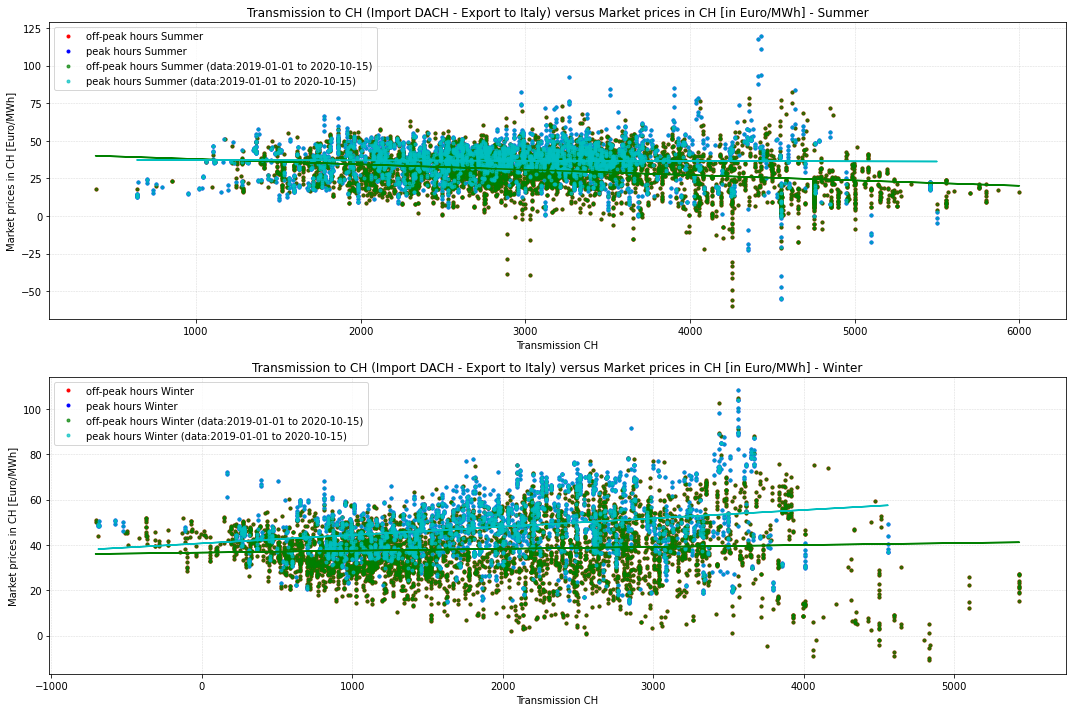

In [60]:
#dependency of prices according to possible import 
ts_TransFromDACH = (ts_TransD_CH[an_index4Presentation] + ts_TransF_CH[an_index4Presentation] + ts_TransAT_CH[an_index4Presentation]) - ts_TransCH_IT[an_index4Presentation]

#drawing time Series
ts_x = ts_TransFromDACH
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission to CH (Import DACH - Export to Italy) versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(-1000, 6000)
#plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission to CH (Import DACH - Export to Italy) versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(-1000, 6000)
#plt.ylim(-45, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion</u>: hard to speak about correlation here, tendency: the higher capacity in transmission for Import (minus Export to Italy) the lower the price, i.e. in Summer 

Q2Q3: 
slope : -3.35E-03 +/- 1.71E-04,  p-value for Hypt. "no slope": 9.09E-83 -> r-value: -0.25
slope : -1.54E-03 +/- 2.38E-04,  p-value for Hypt. "no slope": 1.11E-10 -> r-value: -0.11
Q1Q4: 
slope : -5.93E-03 +/- 5.19E-04,  p-value for Hypt. "no slope": 8.51E-30 -> r-value: -0.17
slope : -6.14E-03 +/- 6.45E-04,  p-value for Hypt. "no slope": 3.65E-21 -> r-value: -0.19


<Figure size 432x288 with 0 Axes>

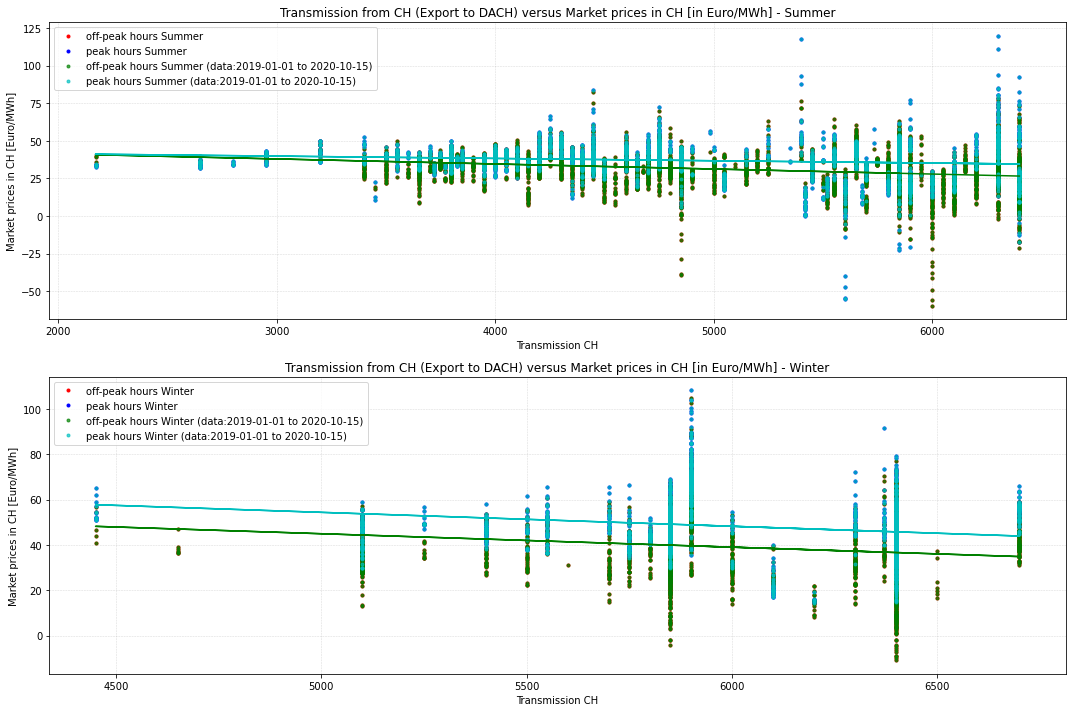

In [61]:
#dependency of prices according to possible export 
ts_TransToDACH = (ts_TransCH_D[an_index4Presentation] + ts_TransCH_F[an_index4Presentation] + ts_TransCH_AT[an_index4Presentation]) #+ ts_TransCH_IT[an_index4Presentation]

#drawing time Series
ts_x = ts_TransToDACH
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission from CH (Export to DACH) versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission from CH (Export to DACH) versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion:</u> almost no dependency from transmission capacity to northern region (as expected cause no congestions). 

Q2Q3: 
slope : 5.66E-03 +/- 1.82E-04,  p-value for Hypt. "no slope": 3.87E-196 -> r-value: 0.38
slope : 2.08E-03 +/- 2.99E-04,  p-value for Hypt. "no slope": 4.32E-12 -> r-value: 0.12
Q1Q4: 
slope : 6.74E-04 +/- 2.54E-04,  p-value for Hypt. "no slope": 7.96E-03 -> r-value: 0.04
slope : -3.42E-03 +/- 3.70E-04,  p-value for Hypt. "no slope": 5.64E-20 -> r-value: -0.18


<Figure size 432x288 with 0 Axes>

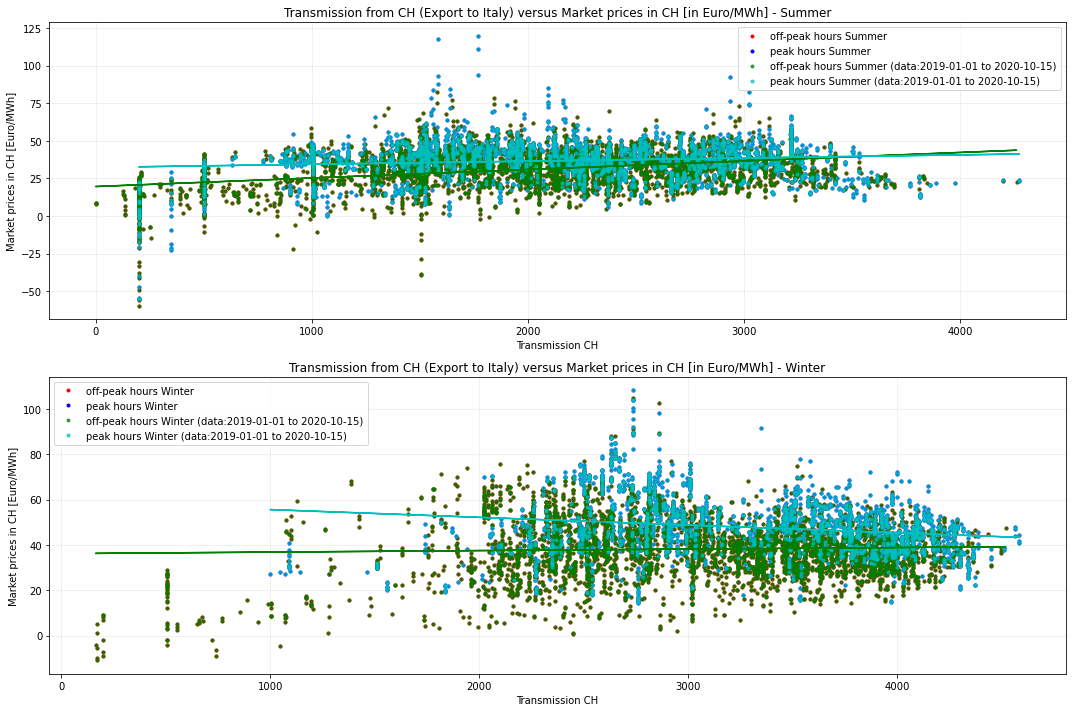

In [62]:
#dependency of prices according to possible export to Italy 
ts_TransToIT = ts_TransCH_IT[an_index4Presentation]
ts_TransFromIT = ts_TransIT_CH[an_index4Presentation]

#drawing time Series
ts_x = ts_TransToIT
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)

plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(2,1,1)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission from CH (Export to Italy) versus Market prices in CH [in Euro/MWh] - Summer')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(2,1,2)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Transmission from CH (Export to Italy) versus Market prices in CH [in Euro/MWh] - Winter')
plt.xlabel('Transmission CH')
plt.ylabel('Market prices in CH [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

#### <u>conclusion:</u> slight dependency from transmission capacity to Italy in summer (high prices in Italy). 

Q2Q3: 
slope : 8.15E-04 +/- 1.15E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.69
slope : 7.36E-04 +/- 1.70E-05,  p-value for Hypt. "no slope": 2.93E-321 -> r-value: 0.61
Q1Q4: 
slope : 5.42E-04 +/- 1.23E-05,  p-value for Hypt. "no slope": 0.00E+00 -> r-value: 0.55
slope : 5.51E-04 +/- 1.90E-05,  p-value for Hypt. "no slope": 5.05E-159 -> r-value: 0.50


<Figure size 432x288 with 0 Axes>

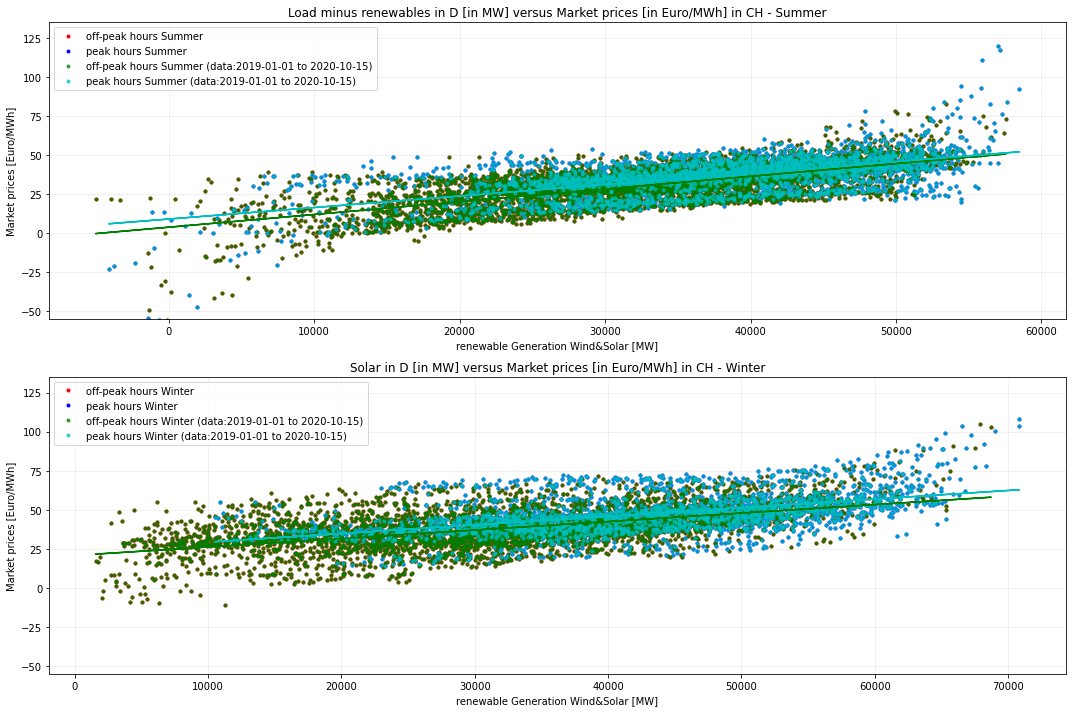

In [63]:
#look at difference between Load and RenGenAll
ts_RenGenAllD = ts_RenGenOffWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenOnWindD.resample('H').mean()[an_index4Presentation] + ts_RenGenSolarD.resample('H').mean()[an_index4Presentation]
ts_Load_h = ts_LoadD.resample('H').mean()[an_index4Presentation]
#ts_Summer_Driver = ts_RenGenSolarD.resample('H').mean()[an_index4Presentation]                                    
ts_Summer_Driver = (ts_Load_h - ts_RenGenAllD) 

#drawing time Series
ts_x = ts_Summer_Driver
ts_y = ts_pricesCH

#Identification of NaNs cause regression would fail and no idea what is plotted
#plot is stable, only adapted in linRegression
a_index_to_drop = ts_x.index[ pd.isna(ts_x) ]
an_other_index_to_drop = ts_y.index[ pd.isna(ts_y) ] 
a_index_to_drop.append(an_other_index_to_drop)


#plot
plt.figure()
fig, axes = plt.subplots(2,1, figsize=(15,10),  tight_layout=True)
a_font_size = 12
plt.subplot(211)
#plt.plot(ts_RenGenAllD[an_index], ts_pricesCH[an_index], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q2Q3_OPH], ts_y[an_index_Q2Q3_OPH], '.r')
plt.plot(ts_x[an_index_Q2Q3_PH], ts_y[an_index_Q2Q3_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q2Q3_OPH_s], ts_y[an_index_Q2Q3_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q2Q3_PH_s], ts_y[an_index_Q2Q3_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q2Q3: ')
        an_index_to_fit_and_plot = an_index_Q2Q3_OPH_s[ np.invert( an_index_Q2Q3_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q2Q3_PH_s[ np.invert( an_index_Q2Q3_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )

#-----------
plt.title('Load minus renewables in D [in MW] versus Market prices [in Euro/MWh] in CH - Summer')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Summer','peak hours Summer', 'off-peak hours Summer ' + a_data_str,'peak hours Summer ' + a_data_str])
else:
    plt.legend(['off-peak hours Summer','peak hours Summer'])
#plt.xlim(-100, 60100)
plt.ylim(-55, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.subplot(212)
#plt.plot(ts_RenGenAllD[an_index], ts_pricesCH[an_index], '.r', alpha = 0.5)
plt.plot(ts_x[an_index_Q1Q4_OPH], ts_y[an_index_Q1Q4_OPH], '.r')
plt.plot(ts_x[an_index_Q1Q4_PH], ts_y[an_index_Q1Q4_PH], '.b')
if a_selection_flag:
    plt.plot(ts_x[an_index_Q1Q4_OPH_s], ts_y[an_index_Q1Q4_OPH_s],  '.g', alpha = 0.7)
    plt.plot(ts_x[an_index_Q1Q4_PH_s], ts_y[an_index_Q1Q4_PH_s],  '.c', alpha = 0.7)
    if a_reggression_flag:
        print('Q1Q4: ')
        an_index_to_fit_and_plot = an_index_Q1Q4_OPH_s[ np.invert( an_index_Q1Q4_OPH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[ an_index_to_fit_and_plot ], ts_y[ an_index_to_fit_and_plot ])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'g', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
        #----
        an_index_to_fit_and_plot = an_index_Q1Q4_PH_s[ np.invert( an_index_Q1Q4_PH_s.isin(a_index_to_drop) ) ] #this because there could be NaNs in data and linregress fails ..
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_x[an_index_to_fit_and_plot], ts_y[an_index_to_fit_and_plot])
        plt.plot(ts_x[an_index_to_fit_and_plot], intercept + slope*ts_x[an_index_to_fit_and_plot], 'c', label='Fitted treated line')
        print ( 'slope : {:2.2E} +/- {:2.2E},  p-value for Hypt. "no slope": {:2.2E} -> r-value: {:4.2f}'.format(slope, std_err, p_value, r_value) )
    
plt.title('Solar in D [in MW] versus Market prices [in Euro/MWh] in CH - Winter')
plt.xlabel('renewable Generation Wind&Solar [MW]')
plt.ylabel('Market prices [Euro/MWh]')
if a_selection_flag:
    a_data_str = '(data:' + a_start + ' to ' + a_end +')'
    plt.legend(['off-peak hours Winter','peak hours Winter', 'off-peak hours Winter ' + a_data_str,'peak hours Winter ' + a_data_str])
else:
    plt.legend(['off-peak hours Winter','peak hours Winter'])
#plt.xlim(-100, 60100)
plt.ylim(-55, 135)
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)


## 3. Setup Fitting Model(s)
We now are going to set up a fitting model. As fitting model we will use *LinearRegression* out of the tool box *Sklearn-Library* (Modul linear_model).<br>
So studying the correlation will help us to choose the relevant time series to include.<br>
Another very important point is the time intervall to choose for training. So we proceed as follows.

Description of Procedure:<br>

1. choose time intervall for training of the Model
2. select data to correlate (incl. creating weight index for seasonality summer/winter and product time peak/off-peak)
3. aggregate them to a dataframe -> consider seasonality summer/winter and product time peak/off-peak <br>
4. convert - Drop Nans and to_numpy().astype(np.float32) <br>
5. Deploy the Model(s) (in our case sklearn LinearRegression and RandomForestRegressor)<br>
6. Compare the Results


### 3.1. choose time intervall for training of the Model
As a first approach we do not choose a time intervall which is to far into the past. Market Condition change quite rapidly.<br>
As Matter of fact the influence of Covid19 is i.e. visible in the consumption data (see further above). So we choose just the scope 2020.

In [64]:
#create index ..
a_fit_start = '2020-01-01'
a_fit_end = '2020-10-15'
an_fit_index = pd.date_range(a_fit_start, a_fit_end, freq = 'h', closed = 'left')

### 3.2. select data to correlate (incl. creating weight index for seasonality summer/winter and product time peak/off-peak)
We will select rather more than less Data in the beginning. <br>
The intention should be that in futureon one should optimize basis of sensitivity study what time series to use or to leave away for training data. <br>
This is an important point because each time serie to rely on must be provided for making predictions. Experience show that to or fro incomplete time series appear on the transparency plattform. This hinders a coninous prediction forecast day by day.

In a first approach we select following data as Input into the Linear Regression Model (Name of time serie - description): <br>
  &emsp; loadCH - consumption forecast Switzerland<br>
  &emsp; loadD - consumption forecast Germany<br>
  &emsp; loadF - consumption forecast France<br> 
  &emsp; loadIT - consumption forecast Italy Zone North<br>
  &emsp; GenerationCH - Overall Generation forecast Switzerland<br>
  &emsp; renewableCH - Renewable Generation forecast Switzerland<br>
  &emsp; GenerationD - Overall Generation forecast Germany<br>
  &emsp; renewableD - Renewable Generation forecast Germany<br>
  &emsp; GenerationF - Overall Generation forecast France<br>
  &emsp; renewableF - Renewable Generation forecast France<br>
  &emsp; GenerationIT - Overall Generation forecast Italy Zone North<br>
  &emsp; renewableIT - Renewable Generation forecast Italy Zone North<br>
  &emsp; TransmissionCapacity to DACH - Transmission forecast to northern Border Switzerland (Sum of Capacity to France, Germany, Austria)<br>
  &emsp; TransmissionCapacity from DACH - Transmission forecast from northern Border Switzerland (Sum of Capacity to France, Germany, Austria)<br>
  &emsp; TransmissionCapacity to Italy - Transmission forecast to Italy (delivering to Italy Zone North)<br>
  &emsp; TransmissionCapacity from Italy - Transmission forecast from Italy (delivering to Italy Zone North)<br>
  &emsp; Weight-Index for hours - off-peak summer / off-peak winter / peak summer / peak winter , the weight is set as the mean of product price (to be built, see further down) <br>
  
  &emsp; further comments:<br>
  &emsp; we should and will consider following distinctions: to fit seasonality and product separately (in case distinction)<br>
  &emsp; Note as a pro memoria: water level reservoir in switzerland or preciptation/Inflow for Run-of-river power plants, data not available or not loaded and will not be fitted yet.<br>
  &emsp; renewable are summed as one time serie (instead of using distinct series for Wind and Solar). This could be further investigated to get better results.

#### creating weight index for seasonality summer/winter and product time peak/off-peak
With a weight index there will be given a bias value for a given time period.<br>
It's a trail to achieve better (means more accurate) results/predictions<br>

In [65]:
#create a wight column for seasonality and product
ts_season_prod = pd.Series( index = an_fit_index, dtype = np.float64, name = 'Season&Product')
#fill it
a_index = an_index_Q2Q3_OPH[an_index_Q2Q3_OPH.isin(an_fit_index)]
ts_season_prod[a_index] = np.ones(a_index.shape[0]) * ts_pricesCH[a_index].mean()
a_index = an_index_Q1Q4_OPH[an_index_Q1Q4_OPH.isin(an_fit_index)]
ts_season_prod[a_index] = np.ones(a_index.shape[0]) * ts_pricesCH[a_index].mean()
a_index = an_index_Q2Q3_PH[an_index_Q2Q3_PH.isin(an_fit_index)]
ts_season_prod[a_index] = np.ones(a_index.shape[0]) * ts_pricesCH[a_index].mean()
a_index = an_index_Q1Q4_PH[an_index_Q1Q4_PH.isin(an_fit_index)]
ts_season_prod[a_index] = np.ones(a_index.shape[0]) * ts_pricesCH[a_index].mean()
#test: see if all positions are set ..
a_test = np.isnan(ts_season_prod.values)
ts_season_prod.values[a_test].shape  # -> result: '(0,)' is fine

(0,)

### 3.3. aggregate data to a dataframe
The aggregation is done including the sample in the last column (means prices). <br>
Reason for doing so is that we still have to get rid of the rows with non-valid values or NaNs (see further down) and doing that is handy by means of a DataFrame.


In [66]:
#aggregate time series, the aggregated time series, like RenGen, have been concatenated in Section 2
df_fit = pd.DataFrame({'LoadCH': ts_LoadCH[an_fit_index], 'LoadD': ts_LoadD.resample('H').mean()[an_fit_index], 'LoadF': ts_LoadF[an_fit_index], 'LoadIT': ts_LoadIT[an_fit_index],
                     'GenCH': ts_GenCH[an_fit_index], 'GenD': ts_GenD[an_fit_index], 'GenF': ts_GenF[an_fit_index], 'GenIT': ts_GenIT[an_fit_index],
                     'RenGenCH': ts_RenGenAllCH[an_fit_index], 'RenGenD': ts_RenGenAllD[an_fit_index], 'RenGenF': ts_RenGenAllF[an_fit_index], 'RenGenIT': ts_RenGenAllIT[an_fit_index], 
                     'TransFromDach': ts_TransFromDACH[an_fit_index], 'TransToDach': ts_TransToDACH[an_fit_index], 'TransToIT': ts_TransToIT[an_fit_index], 'TransFromIT': ts_TransFromIT[an_fit_index],
                     'SeasonAndProduct': ts_season_prod[an_fit_index], 'PricesCH': ts_pricesCH[an_fit_index]   }) 

As a next step we investigate rows of *extrem price values*.<br>
*Extreme price values* are hardest to predict and therefore is of interest to know at what date they appeared.

In [67]:
##### finde index where prices are below zero -> some extreme values
a_threshold_value = 100 # -> set a value in Euro/MWh
a_flag = 'upper'  # -> 'upper' or 'lower'

# get index
if a_flag == 'lower':
    a_index_4_extremP = an_fit_index[ an_fit_index.isin( ts_pricesCH[ (ts_pricesCH.values < a_threshold_value) ].index ) ]
    print('Number of prices found in fitted dataset being ' + a_flag + ' {:3d} is {:3d}'.format(a_threshold_value, np.shape(a_index_4_extremP)[0] ) )
elif a_flag == 'upper':
    a_index_4_extremP = an_fit_index[ an_fit_index.isin( ts_pricesCH[ (ts_pricesCH.values > a_threshold_value) ].index ) ]
    print('Number of prices found in fitted dataset being ' + a_flag + ' {:3d} Euro/Mwh is {:3d}'.format(a_threshold_value, np.shape(a_index_4_extremP)[0] ) )
else:
    a_index_4_extremP = []
    print('no index for extreme price values set..')

#show the dates
#look at the fundamental values of this extreme prices
df_fit.loc[a_index_4_extremP].head(60)

Number of prices found in fitted dataset being upper 100 Euro/Mwh is   3


LoadCH     LoadD  LoadF  LoadIT  GenCH     GenD     GenF  \
2020-09-15 17:00:00  7276.0  58869.00  51350   23879   9512  49607.0  47198.0   
2020-09-15 18:00:00  6920.0  57622.75  50350   24451   9417  51597.0  46805.0   
2020-09-21 17:00:00  7113.0  59026.75  48450   22802   9267  48521.0  49988.0   

                     GenIT  RenGenCH  RenGenD  RenGenF  RenGenIT  \
2020-09-15 17:00:00  21245         5  1879.25   1555.0       6.0   
2020-09-15 18:00:00  21641         0  1685.00    907.0       5.0   
2020-09-21 17:00:00  20933         2  1863.00   1295.0       NaN   

                     TransFromDach  TransToDach  TransToIT  TransFromIT  \
2020-09-15 17:00:00           4432         6300       1768         1768   
2020-09-15 18:00:00           4432         6300       1768         1768   
2020-09-21 17:00:00           4416         5400       1584         1584   

                     SeasonAndProduct  PricesCH  
2020-09-15 17:00:00         33.485324    119.69  
2020-09-15 18:00:00         33.485324    110.74  
2020-09-21 17:00:00         33.485324    117.51

### 3.4. convert - Drop Nans and to_numpy().astype(np.float32)

First provide an overview of *appearing NaNs* over the dataset:

In [68]:
#get the column indexes to iterate
fit_column_index = df_fit.columns
#get col number 
col_number = np.shape( df_fit.columns )[0]

#just check Loop, see what time Series has NaNs and how many
#loop over all columns in the dataframe to fit, find NaNs and count them 
for j in range(0, col_number):
    a_bool_serie_of_nans = df_fit[fit_column_index[j]].isna()
    a_number_of_nans = np.shape( df_fit[ df_fit[fit_column_index[j]].isna().values ] )[0]
    if a_number_of_nans > 0:
        #np.isnan(df_x[a_test_col].values[i]):
        print('Time Serie: {:>15}'.format( fit_column_index[j] )+ ' has NaNs  {:6d}'.format(a_number_of_nans)) 

#alternativ way
print('            Number of NaNs in total : {:6d}'.format( np.shape( df_fit[ df_fit.isna().values ] )[0] ) )
print('Number of rows with at least one NaN value is {:3d} of a total of rows of: {:3d}'.format( df_fit.isnull().any(axis=1).sum() , np.shape(df_fit)[0] ) )

Time Serie:          LoadCH has NaNs       2
Time Serie:            GenD has NaNs     146
Time Serie:         RenGenD has NaNs      46
Time Serie:         RenGenF has NaNs      70
Time Serie:        RenGenIT has NaNs     456
            Number of NaNs in total :    720
Number of rows with at least one NaN value is 718 of a total of rows of: 6912


Let's drop it..

In [69]:
#drop the NaNs
#get indexes we are going to drop
a_index_to_drop = df_fit.index[ df_fit.isnull().any(axis=1).values ]
#drop the rows and do it inplace -> no copy 
df_fit.drop( a_index_to_drop, inplace = True )
#just as a check  
print('After drop - number of rows with at least one NaN : {:3d} of a total of rows of: {:3d}'.format( df_fit.isnull().any(axis=1).sum() , np.shape(df_fit)[0] ) )

After drop - number of rows with at least one NaN :   0 of a total of rows of: 6194


In [70]:
#create the Input for Model
# y first..
df_y = pd.DataFrame( {'pricesCH' : df_fit['PricesCH'] } )
# drop that from to create x
df_x = df_fit.drop(columns=['PricesCH'])

#make numpy arrays for sklearn input .. 
x = df_x.to_numpy().astype(np.float64)
y = df_y.to_numpy().astype(np.float64)

#double check if after conversion no nans
x[np.isnan(x)]

array([], dtype=float64)

finally we're ready ..

### 3.5. Deploy the Model(s)
#### 3.5.1 Linear Regression Model - one Model for all data
As a first Model we are going to fit all in one by LinearRegression Model of Scikit-Learn for the given time intervall.

train mse = 6.9621431441581505
test mse = 6.769403351068247
train mae = 5.282303337119262
test mae = 5.250564025483784
train R2 = 0.7197540276876251
test R2 = 0.7378082504992782


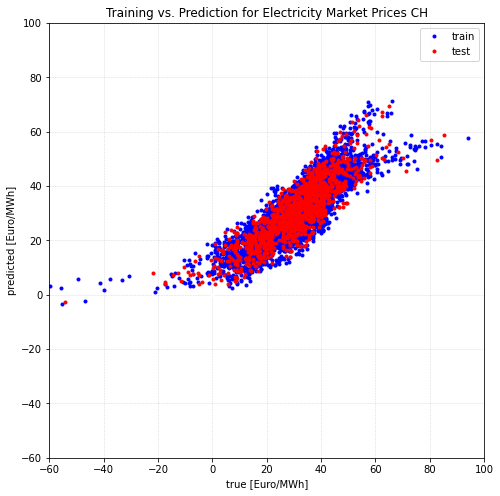

In [71]:
# Solution:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# 1. make train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train = reg.predict(x_train)
y_p_test = reg.predict(x_test)

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize = (8,8))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true [Euro/MWh]')
plt.ylabel('predicted [Euro/MWh]')
plt.gca().set_aspect('equal')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.xlim([-60,100])
plt.ylim([-60,100])
plt.title('Training vs. Prediction for Electricity Market Prices CH')
plt.legend()

#### <u>Conclusion:</u> 
- there is an acceptable approximation for the bulk data. However at the tails - extreme prices near or below 0 Euro/MWh and above 60 Euro/MWh - there appear huge deviations. 
- In the upper region (>60Euro/MWh) there seem to be two regimes, which could appear due to seasonality or product distinction. 
- the fit with mse of 6-7 [Euro^2/MWh^2] is ok but not (yet) good enough for operational purposes.

As a follow up and the main goal we predict a specific day.<br>
With that procedure we are able to predict the day ahead on the basis of given fundamental data from the transparency plattform.

#### 3.5.2. Linear Regression Model - distinctiv Model for season and product
In a next step we implement a differentiation in several fitting engines.<br> 
We will devide data fitting in seasonality and product, tha makes four cases:
1. Winter - Peak
2. Winter - Off-Peak
3. Summer - Peak
4. Summer - Off-Peak

In [72]:
#take the current_index for the data to go on
current_index = df_y.index

#prepare an array to concatenate the result at the end, just for comparing with other models
#create for test and train an empty array for concatenation, delete first element later!
y_p_MLR_train = np.empty([1,1], dtype = np.float64)
y_MLR_train = np.empty([1,1], dtype = np.float64)
y_p_MLR_test =  np.empty([1,1], dtype = np.float64)
y_MLR_test =  np.empty([1,1], dtype = np.float64)

#now we have to devide the data to the distinction, we do that by using indexes for the different cases
#fit for summer peak
current_fit_index_Q2Q3_P = an_index_Q2Q3_PH[an_index_Q2Q3_PH.isin(current_index)]
x_Q2Q3_P = df_x.loc[current_fit_index_Q2Q3_P].to_numpy().astype(np.float64)
y_Q2Q3_P = df_y.loc[current_fit_index_Q2Q3_P].to_numpy().astype(np.float64)
if np.shape(x_Q2Q3_P)[0] > 0:
    # 1. make train/test split
    x_Q2Q3_P_train, x_Q2Q3_P_test, y_Q2Q3_P_train, y_Q2Q3_P_test = train_test_split(x_Q2Q3_P, y_Q2Q3_P, test_size=0.2)
    # 2. fit the model
    reg_Q2Q3_P = linear_model.LinearRegression()
    reg_Q2Q3_P.fit(x_Q2Q3_P_train, y_Q2Q3_P_train)
    # 3. evaluate MSE, MAD, and R2 on train and test datasets
    #prediction:
    y_Q2Q3_P_p_train = reg_Q2Q3_P.predict(x_Q2Q3_P_train)
    y_Q2Q3_P_p_test = reg_Q2Q3_P.predict(x_Q2Q3_P_test)
    #fill it in the result array
    y_p_MLR_train = np.concatenate( (y_p_MLR_train, y_Q2Q3_P_p_train))
    y_MLR_train = np.concatenate( (y_MLR_train, y_Q2Q3_P_train))
    y_p_MLR_test = np.concatenate( (y_p_MLR_test, y_Q2Q3_P_p_test))
    y_MLR_test = np.concatenate( (y_MLR_test, y_Q2Q3_P_test))
    
#fit for winter peak    
current_fit_index_Q1Q4_P = an_index_Q1Q4_PH[an_index_Q1Q4_PH.isin(current_index)]
x_Q1Q4_P = df_x.loc[current_fit_index_Q1Q4_P].to_numpy().astype(np.float64)
y_Q1Q4_P = df_y.loc[current_fit_index_Q1Q4_P].to_numpy().astype(np.float64)
if np.shape(x_Q1Q4_P)[0] > 0:
    # 1. make train/test split
    x_Q1Q4_P_train, x_Q1Q4_P_test, y_Q1Q4_P_train, y_Q1Q4_P_test = train_test_split(x_Q1Q4_P, y_Q1Q4_P, test_size=0.2)
    # 2. fit the model
    reg_Q1Q4_P = linear_model.LinearRegression()
    reg_Q1Q4_P.fit(x_Q1Q4_P_train, y_Q1Q4_P_train)
    # 3. evaluate MSE, MAD, and R2 on train and test datasets
    #prediction:
    y_Q1Q4_P_p_train = reg_Q1Q4_P.predict(x_Q1Q4_P_train)
    y_Q1Q4_P_p_test = reg_Q1Q4_P.predict(x_Q1Q4_P_test)
    #fill it in the result array
    y_p_MLR_train = np.concatenate( (y_p_MLR_train, y_Q1Q4_P_p_train))
    y_MLR_train = np.concatenate( (y_MLR_train, y_Q1Q4_P_train))
    y_p_MLR_test = np.concatenate( (y_p_MLR_test, y_Q1Q4_P_p_test))
    y_MLR_test = np.concatenate( (y_MLR_test, y_Q1Q4_P_test))
    
#fit for summer offpeak
current_fit_index_Q2Q3_OP = an_index_Q2Q3_OPH[an_index_Q2Q3_OPH.isin(current_index)]
x_Q2Q3_OP = df_x.loc[current_fit_index_Q2Q3_OP].to_numpy().astype(np.float64)
y_Q2Q3_OP = df_y.loc[current_fit_index_Q2Q3_OP].to_numpy().astype(np.float64)
if np.shape(x_Q2Q3_OP)[0] > 0:
    # 1. make train/test split
    x_Q2Q3_OP_train, x_Q2Q3_OP_test, y_Q2Q3_OP_train, y_Q2Q3_OP_test = train_test_split(x_Q2Q3_OP, y_Q2Q3_OP, test_size=0.2)
    # 2. fit the model
    reg_Q2Q3_OP = linear_model.LinearRegression()
    reg_Q2Q3_OP.fit(x_Q2Q3_OP_train, y_Q2Q3_OP_train)
    # 3. evaluate MSE, MAD, and R2 on train and test datasets
    #prediction:
    y_Q2Q3_OP_p_train = reg_Q2Q3_OP.predict(x_Q2Q3_OP_train)
    y_Q2Q3_OP_p_test = reg_Q2Q3_OP.predict(x_Q2Q3_OP_test)
    #fill it in the result array
    y_p_MLR_train = np.concatenate( (y_p_MLR_train, y_Q2Q3_OP_p_train))
    y_MLR_train = np.concatenate( (y_MLR_train, y_Q2Q3_OP_train))
    y_p_MLR_test = np.concatenate( (y_p_MLR_test, y_Q2Q3_OP_p_test))
    y_MLR_test = np.concatenate( (y_MLR_test, y_Q2Q3_OP_test))
     
    
#fit for winter offpeak
current_fit_index_Q1Q4_OP = an_index_Q1Q4_OPH[an_index_Q1Q4_OPH.isin(current_index)]
x_Q1Q4_OP = df_x.loc[current_fit_index_Q1Q4_OP].to_numpy().astype(np.float64)
y_Q1Q4_OP = df_y.loc[current_fit_index_Q1Q4_OP].to_numpy().astype(np.float64)
if np.shape(x_Q1Q4_OP)[0] > 0:
    # 1. make train/test split
    x_Q1Q4_OP_train, x_Q1Q4_OP_test, y_Q1Q4_OP_train, y_Q1Q4_OP_test = train_test_split(x_Q1Q4_OP, y_Q1Q4_OP, test_size=0.2)
    # 2. fit the model
    reg_Q1Q4_OP = linear_model.LinearRegression()
    reg_Q1Q4_OP.fit(x_Q1Q4_OP_train, y_Q1Q4_OP_train)
    # 3. evaluate MSE, MAD, and R2 on train and test datasets
    #prediction:
    y_Q1Q4_OP_p_train = reg_Q1Q4_OP.predict(x_Q1Q4_OP_train)
    y_Q1Q4_OP_p_test = reg_Q1Q4_OP.predict(x_Q1Q4_OP_test)
    #fill it in the result array
    y_p_MLR_train = np.concatenate( (y_p_MLR_train, y_Q1Q4_OP_p_train))
    y_MLR_train = np.concatenate( (y_MLR_train, y_Q1Q4_OP_train))
    y_p_MLR_test = np.concatenate( (y_p_MLR_test, y_Q1Q4_OP_p_test))
    y_MLR_test = np.concatenate( (y_MLR_test, y_Q1Q4_OP_test))

#delete the first element of the result array (cause was only for concatenation purpose)
y_p_MLR_train =  np.delete(y_p_MLR_train, 0, axis = 0) 
y_MLR_train =  np.delete(y_MLR_train, 0, axis = 0) 
y_p_MLR_test =  np.delete(y_p_MLR_test, 0, axis = 0) 
y_MLR_test =  np.delete(y_MLR_test, 0, axis = 0) 
       
# show the results for the different regimes
if np.shape(x_Q1Q4_P)[0] > 0 and np.shape(x_Q1Q4_OP)[0] :
    # mse
    print('Q1Q4: ')
    print('train mse = {:2.2e} (Peak)  -  train mse = {:2.2e} (Off-Peak)'.format( np.std(y_Q1Q4_P_train - y_Q1Q4_P_p_train)  ,   np.std(y_Q1Q4_OP_train - y_Q1Q4_OP_p_train) ))
    print('test mse  = {:2.2e} (Peak)  -  test mse  = {:2.2e} (Off-Peak)'.format( np.std(y_Q1Q4_P_test - y_Q1Q4_P_p_test), np.std(y_Q1Q4_OP_test - y_Q1Q4_OP_p_test) ) )
    # mse
    print('train mae = {:2.2e} (Peak)  -  train mae = {:2.2e} (Off-Peak)'.format( np.mean(np.abs(y_Q1Q4_P_train - y_Q1Q4_P_p_train)), np.mean(np.abs(y_Q1Q4_OP_train - y_Q1Q4_OP_p_train))  ) )
    print('test mae  = {:2.2e} (Peak)  -  test mae  = {:2.2e} (Off-Peak)'.format( np.mean(np.abs(y_Q1Q4_P_test - y_Q1Q4_P_p_test)), np.mean(np.abs(y_Q1Q4_OP_test - y_Q1Q4_OP_p_test))) )
    # R2
    print('train R2 = {:2.2e} (Peak) - train R2 = {:2.2e} (Off-Peak) '.format( reg_Q1Q4_P.score(x_Q1Q4_P_train, y_Q1Q4_P_train), reg_Q1Q4_OP.score(x_Q1Q4_OP_train, y_Q1Q4_OP_train)) )
    print('test R2  = {:2.2e} (Peak) - test R2  = {:2.2e} (Off-Peak) '.format( reg_Q1Q4_P.score(x_Q1Q4_P_test, y_Q1Q4_P_test) , reg_Q1Q4_OP.score(x_Q1Q4_OP_test, y_Q1Q4_OP_test)) )
    print('')
if np.shape(x_Q2Q3_P)[0] > 0 and np.shape(x_Q2Q3_OP)[0] :
    # mse
    print('Q2Q3: ')
    print('train mse = {:2.2e} (Peak)  -  train mse = {:2.2e} (Off-Peak)'.format( np.std(y_Q2Q3_P_train - y_Q2Q3_P_p_train)  ,   np.std(y_Q2Q3_OP_train - y_Q2Q3_OP_p_train) ))
    print('test mse  = {:2.2e} (Peak)  -  test mse  = {:2.2e} (Off-Peak)'.format( np.std(y_Q2Q3_P_test - y_Q2Q3_P_p_test), np.std(y_Q2Q3_OP_test - y_Q2Q3_OP_p_test) ) )
    # mse
    print('train mae = {:2.2e} (Peak)  -  train mae = {:2.2e} (Off-Peak)'.format( np.mean(np.abs(y_Q2Q3_P_train - y_Q2Q3_P_p_train)), np.mean(np.abs(y_Q2Q3_OP_train - y_Q2Q3_OP_p_train))  ) )
    print('test mae  = {:2.2e} (Peak)  -  test mae  = {:2.2e} (Off-Peak)'.format( np.mean(np.abs(y_Q2Q3_P_test - y_Q2Q3_P_p_test)), np.mean(np.abs(y_Q2Q3_OP_test - y_Q2Q3_OP_p_test))) )
    # R2
    print('train R2 = {:2.2e} (Peak) - train R2 = {:2.2e} (Off-Peak) '.format( reg_Q2Q3_P.score(x_Q2Q3_P_train, y_Q2Q3_P_train), reg_Q2Q3_OP.score(x_Q2Q3_OP_train, y_Q2Q3_OP_train)) )
    print('test R2  = {:2.2e} (Peak) - test R2  = {:2.2e} (Off-Peak) '.format( reg_Q2Q3_P.score(x_Q2Q3_P_test, y_Q2Q3_P_test) , reg_Q2Q3_OP.score(x_Q2Q3_OP_test, y_Q2Q3_OP_test)) )
    print('')
    
# show the results for the overall 
    print('Overall')
    print('train mse = {:2.2e} overall'.format( np.std(y_MLR_train - y_p_MLR_train)  ))
    print('test mse  = {:2.2e} overall'.format( np.std(y_MLR_test - y_p_MLR_test) )) 
    # mse
    print('train mae = {:2.2e} overall'.format( np.mean(np.abs(y_MLR_train - y_p_MLR_train)) )) 
    print('test mae  = {:2.2e} overall'.format( np.mean(np.abs(y_MLR_test - y_p_MLR_test)) ))
    # R2
    print('Overall Score can not be calculated -> different Model engines')
    print('')


Q1Q4: 
train mse = 3.85e+00 (Peak)  -  train mse = 4.74e+00 (Off-Peak)
test mse  = 3.47e+00 (Peak)  -  test mse  = 4.60e+00 (Off-Peak)
train mae = 3.00e+00 (Peak)  -  train mae = 3.70e+00 (Off-Peak)
test mae  = 2.70e+00 (Peak)  -  test mae  = 3.59e+00 (Off-Peak)
train R2 = 8.03e-01 (Peak) - train R2 = 8.02e-01 (Off-Peak) 
test R2  = 8.33e-01 (Peak) - test R2  = 7.70e-01 (Off-Peak) 

Q2Q3: 
train mse = 5.99e+00 (Peak)  -  train mse = 6.16e+00 (Off-Peak)
test mse  = 5.63e+00 (Peak)  -  test mse  = 6.55e+00 (Off-Peak)
train mae = 4.27e+00 (Peak)  -  train mae = 4.50e+00 (Off-Peak)
test mae  = 4.10e+00 (Peak)  -  test mae  = 4.74e+00 (Off-Peak)
train R2 = 8.37e-01 (Peak) - train R2 = 7.75e-01 (Off-Peak) 
test R2  = 8.50e-01 (Peak) - test R2  = 7.53e-01 (Off-Peak) 

Overall
train mse = 5.57e+00 overall
test mse  = 5.61e+00 overall
train mae = 4.07e+00 overall
test mae  = 4.07e+00 overall
Overall Score can not be calculated -> different Model engines



<Figure size 432x288 with 0 Axes>

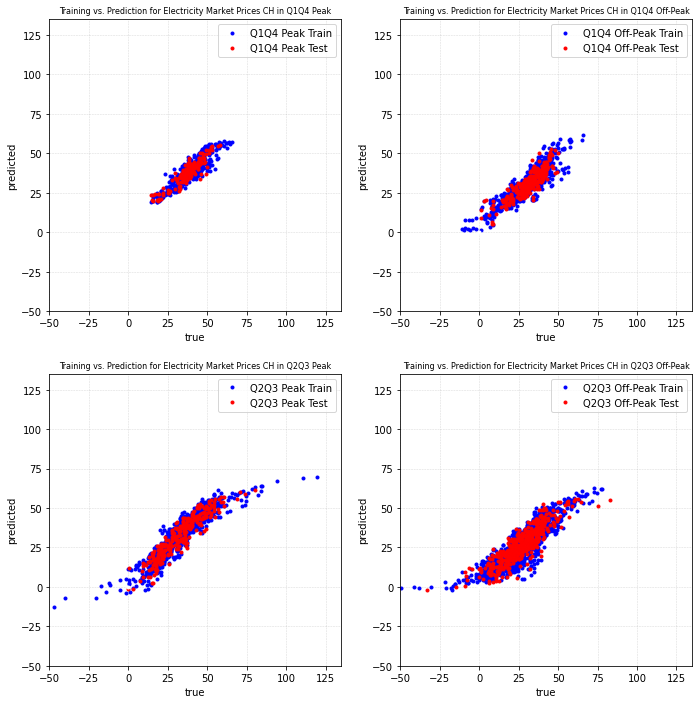

In [73]:
#plot the true vs. predicted for all regime
plt.figure()   
fig, axes = plt.subplots(2,2, figsize=(10,10),  tight_layout=True)
a_font_size = 8

if np.shape(x_Q1Q4_P)[0] > 0 and np.shape(x_Q1Q4_OP)[0]:
    # plot y vs predicted y for test and train parts for "Winter Peak"
    plt.subplot(2,2,1)
    plt.plot(y_Q1Q4_P_train, y_Q1Q4_P_p_train, 'b.', label='Q1Q4 Peak Train')
    plt.plot(y_Q1Q4_P_test, y_Q1Q4_P_p_test, 'r.', label='Q1Q4 Peak Test')
    plt.plot([0], [0], 'w.')  # dummy to have origin
    plt.xlim([-50, 135])
    plt.ylim([-50,135])
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.gca().set_aspect('equal')
    plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
    plt.title('Training vs. Prediction for Electricity Market Prices CH in Q1Q4 Peak', fontsize=a_font_size)
    plt.legend()
    
    # plot y vs predicted y for test and train parts for "Winter Off-Peak"
    plt.subplot(2,2,2)
    plt.plot(y_Q1Q4_OP_train, y_Q1Q4_OP_p_train, 'b.', label='Q1Q4 Off-Peak Train')
    plt.plot(y_Q1Q4_OP_test, y_Q1Q4_OP_p_test, 'r.', label='Q1Q4 Off-Peak Test')
    plt.plot([0], [0], 'w.')  # dummy to have origin
    plt.xlim([-50, 135])
    plt.ylim([-50,135])
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.gca().set_aspect('equal')
    plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
    plt.title('Training vs. Prediction for Electricity Market Prices CH in Q1Q4 Off-Peak', fontsize=a_font_size)
    plt.legend()


if np.shape(x_Q2Q3_P)[0] > 0 and np.shape(x_Q2Q3_OP)[0]:
    # plot y vs predicted y for test and train parts for "Summer Peak"
    plt.subplot(2,2,3)
    plt.plot(y_Q2Q3_P_train, y_Q2Q3_P_p_train, 'b.', label='Q2Q3 Peak Train')
    plt.plot(y_Q2Q3_P_test, y_Q2Q3_P_p_test, 'r.', label='Q2Q3 Peak Test')
    plt.plot([0], [0], 'w.')  # dummy to have origin
    plt.xlim([-50, 135])
    plt.ylim([-50,135])
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.gca().set_aspect('equal')
    plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
    plt.title('Training vs. Prediction for Electricity Market Prices CH in Q2Q3 Peak', fontsize=a_font_size)
    plt.legend()
    
    # plot y vs predicted y for test and train parts for "Summer Off-Peak"
    plt.subplot(2,2,4)
    plt.plot(y_Q2Q3_OP_train, y_Q2Q3_OP_p_train, 'b.', label='Q2Q3 Off-Peak Train')
    plt.plot(y_Q2Q3_OP_test, y_Q2Q3_OP_p_test, 'r.', label='Q2Q3 Off-Peak Test')
    plt.plot([0], [0], 'w.')  # dummy to have origin
    plt.xlim([-50, 135])
    plt.ylim([-50,135])
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.gca().set_aspect('equal')
    plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
    plt.title('Training vs. Prediction for Electricity Market Prices CH in Q2Q3 Off-Peak', fontsize=a_font_size)
    plt.legend()
    

#### <u>Conclusion:</u> 
- the distinction in season and product gives quite an improvement of prediction quality, i.e. for winter. 
- However summer time is still of similar quality and is the main challange.
- linearity in the model is a limitation which we already seen in correlation analysis (i.e. Renewable Generation vs. Prices).
- Possible reason and explanation are: 
    - holiday days in spring (eastern, 1st of Mai, Pentecost) are not considered
    - product distinction in peak and off-peak is not adaquat any more  


#### 3.5.3 RandomForestRegressor Model
As thrid option we deploy (without a deeper understand of the Model) a RandomForestRegressor from Scikit-Learn Library.<br>
The Model takes the input in the same format as the linear Regression Model. <br>
There would configuration options, as a first approach we apply it as given.

train mse = 1.2709172752317677
test mse = 3.315197271785773
train mae = 0.8391317457114031
test mae = 2.2576099273607753
train R2 = 0.9907504913720719
test R2 = 0.9347894030014008


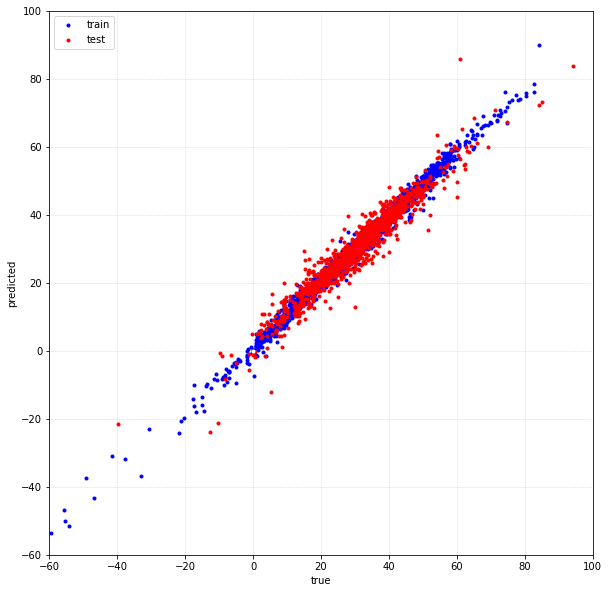

In [74]:
# Solution with RandomForestRegressor:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split  #<- already loaded above

# 1. make train/test split
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x, y, test_size=0.2) 
# y arrays have to be transposed for RandomForestRegressor Model ..
y_train_rf = np.ravel(y_train_rf)
y_test_rf = np.ravel(y_test_rf)

# 2. fit the model
forest_reg = RandomForestRegressor()
forest_reg.fit(x_train_rf, y_train_rf)


# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train_rf = forest_reg.predict(x_train_rf)
y_p_test_rf = forest_reg.predict(x_test_rf)

# mse
print('train mse =', np.std(y_train_rf - y_p_train_rf))
print('test mse =', np.std(y_test_rf - y_p_test_rf))
# mse
print('train mae =', np.mean(np.abs(y_train_rf - y_p_train_rf)))
print('test mae =', np.mean(np.abs(y_test_rf - y_p_test_rf)))
# R2
print('train R2 =', forest_reg.score(x_train_rf, y_train_rf))
print('test R2 =', forest_reg.score(x_test_rf, y_test_rf))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize = (10,10))
plt.plot(y_train_rf, y_p_train_rf, 'b.', label='train')
plt.plot(y_test_rf, y_p_test_rf, 'r.', label='test')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.xlim([-60,100])
plt.ylim([-60,100])
plt.legend()

#### <u>Conclusion:</u> 
- the graphical comparison looks very nice 
- however in the numbers MSE (mean square error) or MAE (mean absolute error) the train and test data give a difference of a factor 2.

#### Compare the results of Linear Regression Model to the Random Forest Regressor

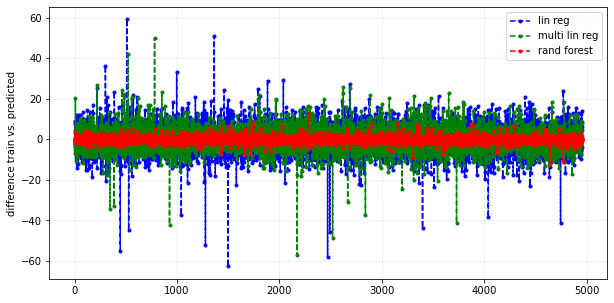

In [75]:
#show difference in trainings lin_reg, multi lin_reg vs. rand_forest
y_diff = y_train - y_p_train
y_diff_MLR = y_MLR_train - y_p_MLR_train
y_diff_rf = y_train_rf - y_p_train_rf

#get an x for y_diff and y_diff_rf
x_vec = range(1, np.shape(y_diff)[0]+1 )
#get an extra x for y_diff_MLR (reason: as splitted otherwise in "train_test_split", there can be different length)
x_vec_MLR = range(1, np.shape(y_diff_MLR)[0]+1 )


plt.figure(figsize=(10,5))
plt.plot(x_vec, y_diff, 'b--.', label='lin reg')
plt.plot(x_vec_MLR, y_diff_MLR, 'g--.', label='multi lin reg')
plt.plot(x_vec, y_diff_rf, 'r--.', label='rand forest')
plt.xlabel('')
plt.ylabel('difference train vs. predicted')
plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.legend()



## Final Result: Get a Day Ahead Predictions of all 3 Models

first set a prediction date (a test for underlaying data will be done):

In [76]:
#show the result
a_date = '2020-04-13'
an_sample_index = pd.date_range( a_date + ' 00:00:00', freq = 'h', periods = 24, closed = 'left')

#first check if there is fundumental data for this -> necessary for prediction 
## check if length indexes "found indexes of df_x in sample_index" and "sample_index" are equal
if np.shape(df_x[df_x.index.isin(an_sample_index)])[0] == np.shape(an_sample_index)[0]:
    print('possible to predict')
else:
    print('not possible to predict cause missing data for prediction!')
    bla3_


possible to predict


Text(0.5, 1.0, 'Hourly Day Ahead Prices and Predictions (different Models) for Electricity Market for Switzerland')

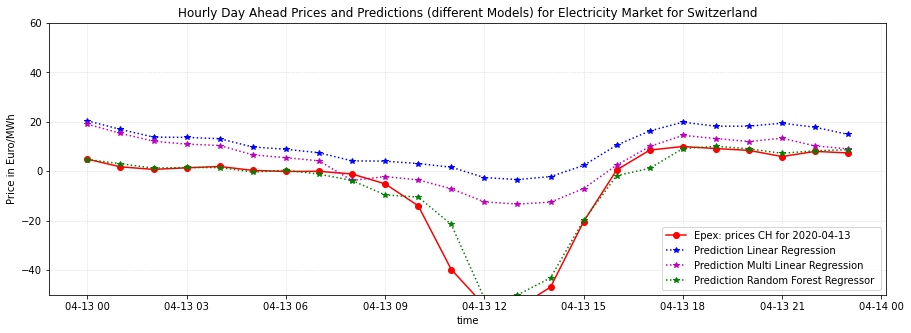

In [77]:
## ---------------------- predict with simple Linear Model
    
#prepare the underlining data from forecast table for prediction
an_x_sample_df = df_x.loc[an_sample_index]
an_x_sample = an_x_sample_df.to_numpy().astype(np.float64)
#predict 
an_y_predict = reg.predict(an_x_sample)    
    
#Output: an_y_predict         
    
## ---------------------- predict with Multi Linear Regression Model   
#prepare the template to concate a predicted y
a_predicted_y = pd.Series( np.zeros(24), index = an_sample_index)

# prepare underlaying data -> devide in winter/summer, peak/offpeak
# and forcast will be also done on the way
# just check if sample index has a hit in the overall offpeak summer index
if an_sample_index.isin(an_index_Q2Q3_OPH)[0]:
    a_time = 'summer'
    a_sample_fit_P_index = an_sample_index[ an_sample_index.isin(an_index_Q2Q3_PH) ]
    a_sample_fit_OP_index = an_sample_index[ an_sample_index.isin(an_index_Q2Q3_OPH) ]
    if np.shape(a_sample_fit_P_index)[0] > 0:              # <- it's a working day, means has peak and offpeak
        sample_Q2Q3_P_x_df = df_x.loc[a_sample_fit_P_index]
        sample_Q2Q3_P_x = sample_Q2Q3_P_x_df.to_numpy().astype(np.float64)
        y_predict_P = reg_Q2Q3_P.predict(sample_Q2Q3_P_x)  # <- fit peak part summer
        
        sample_Q2Q3_OP_x_df = df_x.loc[a_sample_fit_OP_index]
        sample_Q2Q3_OP_x = sample_Q2Q3_OP_x_df.to_numpy().astype(np.float64)
        y_predict_OP = reg_Q2Q3_OP.predict(sample_Q2Q3_OP_x)  # <- fit off-peak part summer
        
        df_predicted_y = pd.DataFrame( np.append ( np.append( y_predict_OP[0:8], y_predict_P) ,  y_predict_OP[8:12]), index = an_sample_index)
        
    else: # -> non-working day -> weekend day
        sample_Q2Q3_OP_x_df = df_x.loc[a_sample_fit_OP_index]
        sample_Q2Q3_OP_x = sample_Q2Q3_OP_x_df.to_numpy().astype(np.float64)
        y_predict_OP = reg_Q2Q3_OP.predict(sample_Q2Q3_OP_x)  # <- fit off-peak part summer
        
        df_predicted_y = pd.DataFrame(y_predict_OP, index = an_sample_index)
    
else:
    a_time = 'winter'
    a_sample_fit_P_index = an_sample_index[ an_sample_index.isin(an_index_Q1Q4_PH) ]
    a_sample_fit_OP_index = an_sample_index[ an_sample_index.isin(an_index_Q1Q4_OPH) ]
    if np.shape(a_sample_fit_P_index)[0] > 0:                # <- it's a working day, means has peak and offpeak
        sample_Q1Q4_P_x_df = df_x.loc[a_sample_fit_P_index]
        sample_Q1Q4_P_x = sample_Q1Q4_P_x_df.to_numpy().astype(np.float64)
        y_predict_P = reg_Q1Q4_P.predict(sample_Q1Q4_P_x)   # <- fit peak part winter
        
        sample_Q1Q4_OP_x_df = df_x.loc[a_sample_fit_OP_index]
        sample_Q1Q4_OP_x = sample_Q1Q4_OP_x_df.to_numpy().astype(np.float64)
        y_predict_OP = reg_Q1Q4_OP.predict(sample_Q1Q4_OP_x)   # <- fit off-peak part winter
        
        df_predicted_y = pd.DataFrame( np.append ( np.append( y_predict_OP[0:8], y_predict_P) ,  y_predict_OP[8:12]), index = an_sample_index)
        
    else: # -> non-working day -> weekend day
        sample_Q1Q4_OP_x_df = df_x.loc[a_sample_fit_OP_index]
        sample_Q1Q4_OP_x = sample_Q1Q4_OP_x_df.to_numpy().astype(np.float64)
        y_predict_OP = reg_Q1Q4_OP.predict(sample_Q1Q4_OP_x)   # <- fit off-peak part winter
        
        df_predicted_y = pd.DataFrame(y_predict_OP, index = an_sample_index)

#Output: an_y_predict_MLR
an_y_predict_MLR = df_predicted_y.values

        
## ---------------------- predict with Random Forest Regressor     

#prepare the underlining data from forecast table for prediction
an_x_sample_df = df_x.loc[an_sample_index]
an_x_sample = an_x_sample_df.to_numpy().astype(np.float64)
#predict 
an_y_predict_rf = forest_reg.predict(an_x_sample)
        
    
## ---------------------- get real y data 
#get the real data
an_y_real_df = df_y.loc[an_sample_index]


## ---------------------- plot
plt.figure(figsize=(15,5))
plt.plot(an_y_real_df.index, an_y_real_df.values, 'o-r')
plt.plot(an_y_real_df.index,an_y_predict, '*:b')
plt.plot(an_y_real_df.index,an_y_predict_MLR, '*:m')
plt.plot(an_y_real_df.index,an_y_predict_rf, '*:g')
plt.xlabel('time')
plt.ylabel('Price in Euro/MWh')
plt.legend(['Epex: prices CH for ' + a_date , 'Prediction Linear Regression ',
            'Prediction Multi Linear Regression ', 
            'Prediction Random Forest Regressor '], 
           loc='lower right')

plt.grid(color='gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.ylim(-50, 60)
plt.title('Hourly Day Ahead Prices and Predictions (different Models) for Electricity Market for Switzerland')



#### <u>final conclusion:</u>
- a prediction on the basis of transparency data with Linear Regression Modell must be adapted for
   - time intervall to choose for training
   - seasonality and hours to consider (Product)
- Nevertheless Correlation study show that linear correlation can not accout for all effects (non-linear dependency visible in data).
- non-linear models (like Random Forest Regressor) seem to achieve better results.
- non-linear models are promising to achieve requirements for operational use.
- extreme prices (like negativ prices or very high prices) are still in question to be forecastable.
- more study to be done in further Modul work (Modul 3).